## stitch HV data ( image & rough label) in MyoSegmenTUM & update csv
- 發現 MyoSegmenTUM 下的 `HV 開頭` 的 data 是分段的，所以嘗試將兩段黏起來


### Configuration **將 csv column name 中具有空格的地方改成 "_" **

In [ ]:
import os
import shutil
import pandas as pd
from collections import defaultdict
import pandas as pd
import re
import numpy as np
import nibabel as nib
from collections import defaultdict
from scipy.ndimage import zoom
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import glob
import random
import numpy.ma as ma

# --- 全域設定 (Global Configurations) ---
# 1. 專案根目錄 (Project Root)
PROJECT_ROOT = "/home/n26141826/114-1_TAICA_cv_Final_Project"

# 2. 原始資料設定 (Raw Data Input)
RAW_DATA_FOLDER = os.path.join(PROJECT_ROOT, "data", "data")
RAW_CSV_FILE = os.path.join(RAW_DATA_FOLDER, "metadata_3D.csv")

# 3. 拼接處理設定 (Stitching Output)
# 拼接後的 3D 檔案與新 CSV 要存哪裡
FIXED_DATA_ROOT = os.path.join(PROJECT_ROOT, "data2", "data_fixed")
OUTPUT_CSV_FILE = os.path.join(FIXED_DATA_ROOT, "metadata_3D_stitched.csv")

# 4. 2D 切片輸出設定 (2D Slices Output)
# 這是最終 PyTorch Dataset 要讀取的 .npy 檔案位置
OUTPUT_SLICE_DIR = os.path.join(PROJECT_ROOT, "data2", "npy_Embedding")

# 5. csv 欄位名稱設定 (CSV Column Names)
DATASET = "Dataset"
PHENOTYPE = "Phenotype"
MRI_SAMPLRE = "MRI_sample" 
MRI_SEQUENCE = "MRI_Sequence"                 # 我把空格改成底線了
IMAGE_3D_FILE = "image_3D_file"               # 我把空格改成底線了
ROUGH_LABEL_3D_FILE = "rough_label_3D_file"
DETAILED_LABEL_3D_FILE = "detailed_label_3D_file"
# 6. 資料篩選條件 (Data Filter)
TARGET_DATASET = 'MyoSegmenTUM'
TARGET_PHENOTYPE = 'Control'

# 7. MRI 序列映射表 (Modality Mapping)
# String -> Int ID
TYPE_MAP = {
    'Water': 0,
    'Fat': 1,
    'FATFRACTION': 5, # 通常將 Fat Fraction 視為 Fat 類別，或依你需求改為獨立 ID
    'T1': 2,
    'T2': 3,
    'STIR': 4
}
# position-embedding 用的類別數量 
# -> 0 : 屁股
# -> 1 : 膝蓋

POSITION_ROUGH_EMBEDDING_COLORS = [
    '#000000', # 0: BG
    '#e6194b', # 1: SA
    '#006400', # 2: RF (Green)
    '#228B22', # 3: VL (Green)
    '#32CD32', # 4: VI (Green)
    '#7CFC00'  # 5: VM (Green)
]
POSITION_DETAILED_EMBEDDING_COLORS = [
    '#000000', # 0: BG
    '#e6194b', # 1: SA
    '#006400', # 2: RF (Green)
    '#228B22', # 3: VL (Green)
    '#32CD32', # 4: VI (Green)
    '#7CFC00', # 5: VM (Green)
    '#911eb4', # 6: AM (Purple)
    '#46f0f0', # 7: GR (Cyan)
    '#00008B', # 8: BFL (Blue)
    '#0000CD', # 9: ST (Blue)
    '#4169E1', # 10: SM (Blue)
    '#87CEEB'  # 11: BFS (Blue)
]
ROUGH_MUSCLE_NAMES = {
    0: 'Background', 1: 'Sartorius', 2: 'Rectus Femoris', 3: 'Vastus Lateralis',
    4: 'Vastus Intermedius', 5: 'Vastus Medialis'
}
DETAIL_MUSCLE_NAMES = {
    0: 'Background', 1: 'Sartorius', 2: 'Rectus Femoris', 3: 'Vastus Lateralis',
    4: 'Vastus Intermedius', 5: 'Vastus Medialis', 6: 'Adductor Magnus',
    7: 'Gracilis', 8: 'Biceps Femoris LH', 9: 'Semitendinosus',
    10: 'Semimembranosus', 11: 'Biceps Femoris SH'
}
# --- 自動建立資料夾 (Auto-create Dirs) ---
for d in [FIXED_DATA_ROOT, OUTPUT_SLICE_DIR,OUTPUT_SLICE_DIR+'/train',OUTPUT_SLICE_DIR+'/test']:
    os.makedirs(d, exist_ok=True)

print("✅ Configuration Loaded Successfully!")
print(f"- Raw CSV: {RAW_CSV_FILE}")
print(f"- Output Stitched CSV: {OUTPUT_CSV_FILE}")
print(f"- Final 2D Output Dir: {OUTPUT_SLICE_DIR}")

✅ Configuration Loaded Successfully!
- Raw CSV: /home/n26141826/114-1_TAICA_cv_Final_Project/data/data/metadata_3D.csv
- Output Stitched CSV: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/metadata_3D_stitched.csv
- Final 2D Output Dir: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding


### 1. copy original dataset (2D+3D)

In [2]:
if os.path.exists(FIXED_DATA_ROOT) and os.path.isdir(FIXED_DATA_ROOT):
    shutil.rmtree(FIXED_DATA_ROOT)
    
shutil.copytree(RAW_DATA_FOLDER, FIXED_DATA_ROOT)
print(f"Copied dataset folder to {FIXED_DATA_ROOT}")

Copied dataset folder to /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed



### 2. delete whole MyoSegmenTUM in copied 3D file (image + rough label)

In [3]:

# read csv from copied folder and write new csv into fixed folder
df = pd.read_csv(RAW_CSV_FILE, sep=',')
# print(df.head(2))
for index, row in df.iterrows():
    dataset = row[DATASET]
    # process path
    if dataset == TARGET_DATASET:
        img_path = row[IMAGE_3D_FILE]
        rough_path = row[ROUGH_LABEL_3D_FILE]
        img_full_path = os.path.join(FIXED_DATA_ROOT, img_path.replace('\\', '/'))
        rough_full_path =  os.path.join(FIXED_DATA_ROOT, rough_path.replace('\\', '/'))
        # delete image and rough label .nii.gz files
        if os.path.exists(img_full_path):
            os.remove(img_full_path)
            print(f"Deleted image file: {img_full_path}")
        if os.path.exists(rough_full_path):
            os.remove(rough_full_path)
            print(f"Deleted rough label file: {rough_full_path}")


Deleted image file: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/image/422_HV001_1_FAT.nii.gz
Deleted rough label file: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/rough_label/422_HV001_1_FAT_rough.nii.gz
Deleted image file: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/image/423_HV001_1_FAT.nii.gz
Deleted rough label file: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/rough_label/423_HV001_1_FAT_rough.nii.gz
Deleted image file: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/image/424_HV001_1_FATFRACTION.nii.gz
Deleted rough label file: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/rough_label/424_HV001_1_FATFRACTION_rough.nii.gz
Deleted image file: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/image/425_HV001_1_FATFRACTION.nii.gz
Deleted rough label file: 

### 3. stitch HV data in MyoSegmenTUM
### 4. add them in to 3D dataset 
### 5. fix `metadata_3D.csv` in copied folder 

In [4]:
class CsvThighStitcher:
    def __init__(self, csv_path):
        self.csv_path = csv_path
        # Regex: (排序號碼)_(群組名稱).nii
        self.pattern = re.compile(r"^(\d+)_(.+)\.nii(\.gz)?$")

    def parse_csv_and_group(self, data_folder):
        """
        讀取 CSV 並將 Image 與 Label 綁定在一起分組
        Return:
            groups: dict
            Key = 'HV011_FATFRACTION'
            Value = list of tuples: (sort_num, img_path, rough_path, raw_row_series)
        """
        print(f"Reading CSV: {self.csv_path}")
        df = pd.read_csv(self.csv_path, sep=',') 
        
        # Filter
        target_df = df[(df[DATASET] == TARGET_DATASET) & (df[PHENOTYPE] == TARGET_PHENOTYPE)]
        print(f"Found {len(target_df)} rows for 'MyoSegmenTUM' & 'Control'.")

        groups = defaultdict(list)
        
        for idx, row in target_df.iterrows():
            img_path = row[IMAGE_3D_FILE]
            rough_path = row[ROUGH_LABEL_3D_FILE]
            
            # 處理路徑分隔符號
            imgname = img_path.replace('\\', '/').split('/')[-1]
            # roughname 其實不需要 parse regex，因為通常跟 imgname 是對應的，
            # 我們假設 imgname 的 sort_num 就是這組資料的順序
            
            img_path = img_path.replace('\\', '/')
            rough_path = rough_path.replace('\\', '/')
            
            # 使用 Regex 解析檔名
            match = self.pattern.match(imgname)
            
            if match:
                sort_num = int(match.group(1)) # 轉成 int 以便排序
                group_key = match.group(2)     # 例如 "HV011_FATFRACTION"
                
                # 關鍵修改：將 Img, Rough, 和 原始Row 全部打包
                groups[group_key].append((sort_num, img_path, rough_path, row))
                
                # print(f"Parsed: {imgname} -> Key: {group_key}, Sort: {sort_num}")
            else:
                print(f"[Warning] Filename pattern mismatch: {imgname}")

        return groups

    def process_groups(self, groups):
        """
        執行拼接 (同時拼接 Image 和 Rough Label)
        """            
        valid_pairs = 0
        orphans = []
        ambiguous = []
        
        # 用來收集拼接後的資料，傳給 update_csv 使用
        # 結構: list of new rows (Series)
        stitched_rows_data = [] 

        print(f"\n--- Starting Stitching Process ---")

        for key, items in groups.items():
            count = len(items)
            
            if count == 2:
                # === 完美配對 (Case A) ===
                # items 是 list of (sort_num, img_path, rough_path, row)
                # 根據 sort_num 排序: 小(Upper) -> 大(Lower)
                items.sort(key=lambda x: x[0]) 
                
                upper_item = items[0] 
                lower_item = items[1]
                
                # 1. 拼接 Image
                success_img, output_img_name = self.stitch_pair(
                    upper_item[1], lower_item[1], # img paths
                    upper_item[0], key,           # sort_num, key
                    is_label=False
                )
                
                # 2. 拼接 Label (Order=0 Nearest Neighbor)
                success_rough, output_rough_name = self.stitch_pair(
                    upper_item[2], lower_item[2], # rough paths
                    upper_item[0], key,           # sort_num, key
                    is_label=True
                )

                if success_img and success_rough:
                    valid_pairs += 1
                    
                    # === 準備更新 CSV 的資料 ===
                    # 複製 Upper 的原始資料當作基底
                    new_row = upper_item[3].copy()
                    
                    # 產生新的檔名 (需與 stitch_pair 中的存檔邏輯一致)
                    # 邏輯: {Upper_Sort_Num}_full_{Key}.nii.gz
                    new_filename = f"{upper_item[0]}_full_{key}.nii.gz"
                    
                    # 更新路徑 (存相對路徑或絕對路徑皆可，這裡示範存 output 資料夾下的路徑)
                    new_row[IMAGE_3D_FILE] = output_img_name.replace('/', '\\')
                    new_row[ROUGH_LABEL_3D_FILE] = output_rough_name.replace('/', '\\')
                    
                    stitched_rows_data.append(new_row)
                    
            elif count < 2:
                orphans.append(key)
            else:
                ambiguous.append((key, count))

        # --- Report ---
        print(f"\nProcessed {valid_pairs} pairs successfully.")
        if orphans: 
            print(f"[Warning] {len(orphans)} orphans found. -- non added to output folder.")
            for orphan in orphans:
                print(f"  - Orphan group: {orphan}")
        if ambiguous: 
            print(f"[Warning] {len(ambiguous)} ambiguous groups found. -- none added to output folder.")
            for ambi in ambiguous:
                print(f"  - Ambiguous group: {ambi[0]} with {ambi[1]} items")
        
        return stitched_rows_data

    def stitch_pair(self, subpath_u, subpath_l, sort_num, group_key, is_label=False):
        """
        通用拼接函式 (可處理 Image 或 Label)
        """
        try:
            path_l = os.path.join(RAW_DATA_FOLDER, subpath_l)
            path_u = os.path.join(RAW_DATA_FOLDER, subpath_u)
            print(f"subpath_u: {subpath_u}")
            if not os.path.exists(path_u) or not os.path.exists(path_l):
                print(f"[Error] File missing for {group_key} - {path_u} or {path_l} not found.")
                return False

            img_u = nib.load(path_u)
            img_l = nib.load(path_l)
            data_u = img_u.get_fdata()
            data_l = img_l.get_fdata()
            
            # Resize logic
            if data_u.shape[:2] != data_l.shape[:2]:
                target_h = min(data_u.shape[0], data_l.shape[0])
                target_w = min(data_u.shape[1], data_l.shape[1])
                # Label 用 order=0 (Nearest), Image 用 order=1 (Linear)
                order = 0 if is_label else 1
                data_u = resize_image(data_u, (target_h, target_w, data_u.shape[2]), order)
                data_l = resize_image(data_l, (target_h, target_w, data_l.shape[2]), order)
            
            # 拼接
            data_l = data_l[:, :, :-1]
            data_u = data_u[:, :, 1:]
            stitched_data = np.concatenate([data_l, data_u], axis=2)
            
            # 存檔
            new_img = nib.Nifti1Image(stitched_data, img_u.affine, img_u.header)
            save_name = f"{sort_num}_{group_key}.nii.gz"
            output_name = os.path.join(os.path.dirname(subpath_l), save_name)
            save_path = os.path.join(FIXED_DATA_ROOT, output_name)
            nib.save(new_img, save_path)
            print(f"[Info] Stitched saved: {save_path}")
            
            return True, output_name
        except Exception as e:
            print(f"[Error] Stitching failed for {group_key}: {e}")
            return False, None

def resize_image(image, target_shape, order=1):
    current_shape = image.shape
    zoom_factors = [
        target_shape[0] / current_shape[0],
        target_shape[1] / current_shape[1],
        target_shape[2] / current_shape[2]
    ]
    return zoom(image, zoom_factors, order=order)

def update_csv_direct(original_csv_path, output_csv_path, new_rows_list):
    """
    直接接收處理好的 new_rows_list 並寫入新的 CSV
    """
    print(f"\n--- Generating Updated CSV: {output_csv_path} ---")
    
    # 1. 讀取原始 CSV (為了保留那些 "不需要拼接" 的資料，例如其他 Dataset 的資料)
    df = pd.read_csv(original_csv_path)
    
    # 2. 移除舊的 "MyoSegmenTUM + Control" 資料
    # 我們要用新生成的 stitched rows 來取代它們
    # 條件: Dataset不是MyoSegmenTUM 或者 Phenotype不是Control 的資料要保留
    df_kept = df[~(df[DATASET] == TARGET_DATASET)]
    
    # 3. 建立新資料的 DataFrame
    if new_rows_list:
        df_new = pd.DataFrame(new_rows_list)
        
        # 4. 合併 (保留的舊資料 + 拼接後的新資料)
        df_final = pd.concat([df_kept, df_new], ignore_index=True)
        
        # 5. 存檔
        df_final.to_csv(output_csv_path, index=False)
        print(f"Success! Updated CSV saved with {len(df_final)} rows.")
    else:
        print("No new stitched rows to update. CSV remains unchanged.")

In [5]:
# 設定路徑
if not os.path.exists(RAW_CSV_FILE):
    print("CSV file not found.")
    exit()

stitcher = CsvThighStitcher(RAW_CSV_FILE)

# 1. Parse & Group (只跑一次，同時包含 Img 和 Rough 的資訊)
grouped_data = stitcher.parse_csv_and_group(RAW_DATA_FOLDER)

# 2. Process & Stitch (回傳可以用來寫入 CSV 的 rows)
stitched_rows = stitcher.process_groups(grouped_data)

# 3. Update CSV (直接拿上面的結果來存，不用再 parse 一次)
update_csv_direct(RAW_CSV_FILE, OUTPUT_CSV_FILE, stitched_rows)

Reading CSV: /home/n26141826/114-1_TAICA_cv_Final_Project/data/data/metadata_3D.csv
Found 117 rows for 'MyoSegmenTUM' & 'Control'.

--- Starting Stitching Process ---
subpath_u: 3D_dataset/train/image/422_HV001_1_FAT.nii.gz
[Info] Stitched saved: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/image/422_HV001_1_FAT.nii.gz
subpath_u: 3D_dataset/train/rough_label/422_HV001_1_FAT_rough.nii.gz
[Info] Stitched saved: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/rough_label/422_HV001_1_FAT.nii.gz
subpath_u: 3D_dataset/train/image/424_HV001_1_FATFRACTION.nii.gz
[Info] Stitched saved: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/image/424_HV001_1_FATFRACTION.nii.gz
subpath_u: 3D_dataset/train/rough_label/424_HV001_1_FATFRACTION_rough.nii.gz
[Info] Stitched saved: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/rough_label/424_HV001_1_FATFRACTION.nii.gz
subpath_u: 3D

### 6. convert 3D to 2D & add position, measure_type embedding 

In [8]:
def get_type_id(sequence_name):
    """將文字類別轉為整數 ID"""
    # 移除可能的空白並轉 Title case (e.g., " water " -> "Water")
    clean_name = str(sequence_name).strip()
    # 模糊比對或直接查表
    for key, val in TYPE_MAP.items():
        if key.upper() in clean_name.upper():
            return val
    return -1 # 未知類別

# ==========================================
# 2. 執行切片與 Embedding 注入
# ==========================================
print(f"Reading CSV: {OUTPUT_CSV_FILE}")
df = pd.read_csv(OUTPUT_CSV_FILE)
print(f"Total subjects to process: {len(df)}")
fail_files = []
success_count = 0
fail_count = 0

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Slicing 3D Volumes"):
    # 1. 取得路徑 (修正 Windows/Linux 分隔符號)
    sub_img_path = str(row[IMAGE_3D_FILE]).replace('\\', '/')
    sub_rough_lbl_path = str(row[ROUGH_LABEL_3D_FILE]).replace('\\', '/')
    sub_detail_lbl_path = str(row[DETAILED_LABEL_3D_FILE]).replace('\\', '/')
    img_path = os.path.join(FIXED_DATA_ROOT, sub_img_path) 
    rough_lbl_path = os.path.join(FIXED_DATA_ROOT, sub_rough_lbl_path)
    
    has_detail = False
    detail_path = None
    detail_lbl_path = os.path.join(FIXED_DATA_ROOT, sub_detail_lbl_path)
    print(f"detail_lbl_path: {detail_lbl_path}")
    if os.path.exists(detail_lbl_path):
        has_detail = True
    
    # 取得 MRI 序列類別
    seq_name = row.get(MRI_SEQUENCE) # 假如 CSV 有這欄
    type_idx = get_type_id(seq_name)
    MRI_sample = row.get(MRI_SAMPLRE, "")
    
    print(f"MRI_sample: {MRI_sample}")
    
    try:
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"File not found: {img_path}")

        # 2. 讀取 NIfTI
        img_obj = nib.load(img_path)
        rough_lbl_obj = nib.load(rough_lbl_path)
        detail_lbl_obj = nib.load(detail_lbl_path) if has_detail else None
        
        # 轉為 Numpy Array (H, W, D)
        img_vol = img_obj.get_fdata()
        rough_lbl_vol = rough_lbl_obj.get_fdata()
        detail_lbl_vol = detail_lbl_obj.get_fdata() if has_detail else np.zeros_like(rough_lbl_vol)
        
        vol_max = np.max(img_vol)
        
        # 3. 獲取維度資訊
        h, w, d = img_vol.shape
        filename = os.path.basename(img_path)
        
        # 4. 開始切片 (Slice along Z-axis)
        for z in range(d):
            # --- A. 提取資料 ---
            slice_img = img_vol[:, :, z]
            slice_rough_lbl = rough_lbl_vol[:, :, z]
            slice_detail_lbl = detail_lbl_vol[:, :, z]
            
            # 刪掉屁股附近全黑的切片
            if np.max(slice_rough_lbl) == 0:
                print(f"[Info] Skipping slice {z} of {filename} due to empty rough label.")
                # 跳過全黑標註或有 NaN 的切片
                continue
            
            slice_img = np.rot90(slice_img, k=-1)
            slice_rough_lbl = np.rot90(slice_rough_lbl, k=-1)
            slice_detail_lbl = np.rot90(slice_detail_lbl, k=-1)
            
            new_h, new_w = slice_img.shape
            
            # --- B. 數值正規化 (Normalization) ---
            # 雖然不改大小，但數值建議先縮放到 0-1，避免存成 float32 時數值過大
            if vol_max > 0:
                slice_img = slice_img / vol_max
            
            # --- C. 計算 Embedding ---
            # Position Embedding: 相對位置 (0.0 ~ 1.0)
            z_pos = 1.0 - (z / (d - 1)) if d > 1 else 0.0
            # z_pos = 1-z_pos  # 反轉位置，0.0 = 屁股, 1.0 = 膝蓋
            
            # --- D. 打包 (Dictionary) ---
            save_data = {
                "image": slice_img.astype(np.float32),              # (H, W) 原尺寸
                "rough_label": slice_rough_lbl.astype(np.uint8),    # (H, W) 原尺寸
                "detail_label": slice_detail_lbl.astype(np.uint8),  # (H, W) 原尺寸
                "has_detail": np.bool_(has_detail),                # 是否有詳細標註
                "z_pos": np.float32(z_pos),                         # 純量
                "this_slice": int(z+1),                         # 純量
                "total_slices": int(d),                        # 純量
                "type_idx": int(type_idx),                          # 純量
                "original_shape": (new_h, new_w),                   # 紀錄原始大小方便 debug
                "source_file": filename,
                "MRI_sample": MRI_sample
            }
            
            # --- E. 存檔 (.npy) ---
            # 檔名範例: 533_1_HV014_FAT.npy
            # file_name = os.path.splitext(filename)[0].split('_')
            slice_name = os.path.splitext(filename)[0].split('.')[0].split('_')            
            save_name = f"{slice_name[0]}_{type_idx}_{'_'.join(slice_name[1:])}_slice{z:03d}.npy"
            save_path = os.path.join(OUTPUT_SLICE_DIR, sub_img_path.split('/')[-3], str(save_name))
            print(f"[Info] Saved slice: {save_path}")
            
            np.save(save_path, save_data)
            
        success_count += 1

    except Exception as e:
        print(f"[Error] Failed {img_path}: {e}")
        fail_files.append(img_path)
        fail_count += 1

print(f"\nProcessing Done!")
print(f"Success Volumes: {success_count}")
print(f"Failed Volumes : {fail_count}")
print(f"Failed Files  : {fail_files}")
print(f"Saved to: {OUTPUT_SLICE_DIR}")

Reading CSV: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/metadata_3D_stitched.csv
Total subjects to process: 480


Slicing 3D Volumes:   0%|          | 0/480 [00:00<?, ?it/s]

Slicing 3D Volumes:   0%|          | 2/480 [00:00<00:44, 10.67it/s]

detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_label/0_THIGH_001_Fat_detailed.nii.gz
MRI_sample: THIGH_001
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/0_1_THIGH_001_Fat_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/0_1_THIGH_001_Fat_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/0_1_THIGH_001_Fat_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/0_1_THIGH_001_Fat_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/0_1_THIGH_001_Fat_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/0_1_THIGH_001_Fat_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/0_1_THIGH_00

Slicing 3D Volumes:   1%|          | 4/480 [00:00<00:36, 12.90it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/2_4_THIGH_001_STIR_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/2_4_THIGH_001_STIR_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/2_4_THIGH_001_STIR_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/2_4_THIGH_001_STIR_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/2_4_THIGH_001_STIR_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/2_4_THIGH_001_STIR_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/2_4_THIGH_001_STIR_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/2_4_THIGH_001_STIR_slice007.npy
[Info] Saved sli

Slicing 3D Volumes:   2%|▏         | 8/480 [00:00<00:31, 15.07it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/5_0_THIGH_001_Water_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/5_0_THIGH_001_Water_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/5_0_THIGH_001_Water_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/5_0_THIGH_001_Water_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/5_0_THIGH_001_Water_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/5_0_THIGH_001_Water_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/5_0_THIGH_001_Water_slice009.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/5_0_THIGH_001_Water_slice010.npy
[Info] S

Slicing 3D Volumes:   2%|▎         | 12/480 [00:00<00:31, 15.00it/s]

[Info] Skipping slice 11 of 8_THIGH_002_T1.nii.gz due to empty rough label.
[Info] Skipping slice 12 of 8_THIGH_002_T1.nii.gz due to empty rough label.
[Info] Skipping slice 13 of 8_THIGH_002_T1.nii.gz due to empty rough label.
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_label/9_THIGH_002_T2_detailed.nii.gz
MRI_sample: THIGH_002
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/9_3_THIGH_002_T2_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/9_3_THIGH_002_T2_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/9_3_THIGH_002_T2_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/9_3_THIGH_002_T2_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/9_3_THIGH_002_T2_slice004.npy
[In

Slicing 3D Volumes:   3%|▎         | 14/480 [00:00<00:31, 14.89it/s]

detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_label/12_THIGH_003_Fat_detailed.nii.gz
MRI_sample: THIGH_003
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/12_1_THIGH_003_Fat_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/12_1_THIGH_003_Fat_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/12_1_THIGH_003_Fat_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/12_1_THIGH_003_Fat_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/12_1_THIGH_003_Fat_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/12_1_THIGH_003_Fat_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/12_1_

Slicing 3D Volumes:   4%|▍         | 18/480 [00:01<00:29, 15.60it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/15_0_THIGH_003_Water_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/15_0_THIGH_003_Water_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/15_0_THIGH_003_Water_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/15_0_THIGH_003_Water_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/15_0_THIGH_003_Water_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/15_0_THIGH_003_Water_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/15_0_THIGH_003_Water_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/15_0_THIGH_003_Water_slice007.npy


Slicing 3D Volumes:   5%|▍         | 22/480 [00:01<00:28, 15.89it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/19_3_THIGH_004_T2_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/19_3_THIGH_004_T2_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/19_3_THIGH_004_T2_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/19_3_THIGH_004_T2_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/19_3_THIGH_004_T2_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/19_3_THIGH_004_T2_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/19_3_THIGH_004_T2_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/19_3_THIGH_004_T2_slice007.npy
[Info] Saved slice: /hom

Slicing 3D Volumes:   5%|▌         | 24/480 [00:01<00:29, 15.45it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/22_1_THIGH_005_Fat_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/22_1_THIGH_005_Fat_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/22_1_THIGH_005_Fat_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/22_1_THIGH_005_Fat_slice009.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/22_1_THIGH_005_Fat_slice010.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/22_1_THIGH_005_Fat_slice011.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/22_1_THIGH_005_Fat_slice012.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/22_1_THIGH_005_Fat_slice013.npy
detail_lbl_path: /home/n

Slicing 3D Volumes:   6%|▌         | 28/480 [00:01<00:30, 14.58it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/25_0_THIGH_005_Water_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/25_0_THIGH_005_Water_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/25_0_THIGH_005_Water_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/25_0_THIGH_005_Water_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/25_0_THIGH_005_Water_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/25_0_THIGH_005_Water_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/25_0_THIGH_005_Water_slice009.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/25_0_THIGH_005_Water_slice010.npy
[Info] S

Slicing 3D Volumes:   6%|▋         | 30/480 [00:02<00:31, 14.50it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/28_2_THIGH_006_T1_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/28_2_THIGH_006_T1_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/28_2_THIGH_006_T1_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/28_2_THIGH_006_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/28_2_THIGH_006_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/28_2_THIGH_006_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/28_2_THIGH_006_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/28_2_THIGH_006_T1_slice007.npy
[Info] Saved slice: /hom

Slicing 3D Volumes:   7%|▋         | 34/480 [00:02<00:31, 14.09it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/31_1_THIGH_007_Fat_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/31_1_THIGH_007_Fat_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/31_1_THIGH_007_Fat_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/31_1_THIGH_007_Fat_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/31_1_THIGH_007_Fat_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/31_1_THIGH_007_Fat_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/31_1_THIGH_007_Fat_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/31_1_THIGH_007_Fat_slice007.npy
[Info] Saved sli

Slicing 3D Volumes:   8%|▊         | 36/480 [00:02<00:32, 13.76it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/34_3_THIGH_007_T2_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/34_3_THIGH_007_T2_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/34_3_THIGH_007_T2_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/34_3_THIGH_007_T2_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/34_3_THIGH_007_T2_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/34_3_THIGH_007_T2_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/34_3_THIGH_007_T2_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/34_3_THIGH_007_T2_slice007.npy
[Info] Saved slice: /hom

Slicing 3D Volumes:   8%|▊         | 40/480 [00:02<00:35, 12.32it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/37_1_THIGH_008_Fat_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/37_1_THIGH_008_Fat_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/37_1_THIGH_008_Fat_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/37_1_THIGH_008_Fat_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/37_1_THIGH_008_Fat_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/37_1_THIGH_008_Fat_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/37_1_THIGH_008_Fat_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/37_1_THIGH_008_Fat_slice007.npy
[Info] Saved sli

Slicing 3D Volumes:   9%|▉         | 42/480 [00:02<00:35, 12.29it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/40_0_THIGH_008_Water_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/40_0_THIGH_008_Water_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/40_0_THIGH_008_Water_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/40_0_THIGH_008_Water_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/40_0_THIGH_008_Water_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/40_0_THIGH_008_Water_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/40_0_THIGH_008_Water_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/40_0_THIGH_008_Water_slice007.npy


Slicing 3D Volumes:   9%|▉         | 44/480 [00:03<00:35, 12.12it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/43_4_THIGH_009_STIR_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/43_4_THIGH_009_STIR_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/43_4_THIGH_009_STIR_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/43_4_THIGH_009_STIR_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/43_4_THIGH_009_STIR_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/43_4_THIGH_009_STIR_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/43_4_THIGH_009_STIR_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/43_4_THIGH_009_STIR_slice007.npy
[Info] S

Slicing 3D Volumes:  10%|█         | 48/480 [00:03<00:35, 12.05it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/45_3_THIGH_009_T2_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/45_3_THIGH_009_T2_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/45_3_THIGH_009_T2_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/45_3_THIGH_009_T2_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/45_3_THIGH_009_T2_slice009.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/45_3_THIGH_009_T2_slice010.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/45_3_THIGH_009_T2_slice011.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/45_3_THIGH_009_T2_slice012.npy
[Info] Saved slice: /hom

Slicing 3D Volumes:  11%|█         | 52/480 [00:04<00:55,  7.78it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/49_2_THIGH_010_T1_slice009.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/49_2_THIGH_010_T1_slice010.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/49_2_THIGH_010_T1_slice011.npy
[Info] Skipping slice 12 of 49_THIGH_010_T1.nii.gz due to empty rough label.
[Info] Skipping slice 13 of 49_THIGH_010_T1.nii.gz due to empty rough label.
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_label/50_THIGH_010_T2_detailed.nii.gz
MRI_sample: THIGH_010
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/50_3_THIGH_010_T2_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/50_3_THIGH_010_T2_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/

Slicing 3D Volumes:  11%|█▏        | 54/480 [00:05<01:41,  4.18it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/53_1_THIGH_011_Fat_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/53_1_THIGH_011_Fat_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/53_1_THIGH_011_Fat_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/53_1_THIGH_011_Fat_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/53_1_THIGH_011_Fat_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/53_1_THIGH_011_Fat_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/53_1_THIGH_011_Fat_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/53_1_THIGH_011_Fat_slice007.npy
[Info] Saved slice: /hom

Slicing 3D Volumes:  12%|█▏        | 56/480 [00:05<01:24,  5.01it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/54_2_THIGH_011_T1_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/54_2_THIGH_011_T1_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/54_2_THIGH_011_T1_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/54_2_THIGH_011_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/54_2_THIGH_011_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/54_2_THIGH_011_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/54_2_THIGH_011_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/54_2_THIGH_011_T1_slice007.npy
[Info] Saved slice: /home/n26141

Slicing 3D Volumes:  12%|█▏        | 57/480 [00:05<01:17,  5.46it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/56_0_THIGH_011_Water_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/56_0_THIGH_011_Water_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/56_0_THIGH_011_Water_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/56_0_THIGH_011_Water_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/56_0_THIGH_011_Water_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/56_0_THIGH_011_Water_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/56_0_THIGH_011_Water_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/56_0_THIGH_011_Water_slice007.npy
[Info] S

Slicing 3D Volumes:  12%|█▏        | 58/480 [00:06<01:44,  4.03it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/57_1_THIGH_012_Fat_slice010.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/57_1_THIGH_012_Fat_slice011.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/57_1_THIGH_012_Fat_slice012.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/57_1_THIGH_012_Fat_slice013.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/57_1_THIGH_012_Fat_slice014.npy
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_label/58_THIGH_012_Fat_detailed.nii.gz
MRI_sample: THIGH_012
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/58_1_THIGH_012_Fat_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/58_1_

Slicing 3D Volumes:  12%|█▏        | 59/480 [00:06<02:24,  2.91it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/58_1_THIGH_012_Fat_slice013.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/58_1_THIGH_012_Fat_slice014.npy
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_label/59_THIGH_012_T1_detailed.nii.gz
MRI_sample: THIGH_012
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/59_2_THIGH_012_T1_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/59_2_THIGH_012_T1_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/59_2_THIGH_012_T1_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/59_2_THIGH_012_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/59_2_THIGH

Slicing 3D Volumes:  12%|█▎        | 60/480 [00:07<02:43,  2.56it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/59_2_THIGH_012_T1_slice010.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/59_2_THIGH_012_T1_slice011.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/59_2_THIGH_012_T1_slice012.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/59_2_THIGH_012_T1_slice013.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/59_2_THIGH_012_T1_slice014.npy
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_label/60_THIGH_012_T2_detailed.nii.gz
MRI_sample: THIGH_012
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/60_3_THIGH_012_T2_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/60_3_THIGH_0

Slicing 3D Volumes:  13%|█▎        | 61/480 [00:07<02:23,  2.93it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/60_3_THIGH_012_T2_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/60_3_THIGH_012_T2_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/60_3_THIGH_012_T2_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/60_3_THIGH_012_T2_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/60_3_THIGH_012_T2_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/60_3_THIGH_012_T2_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/60_3_THIGH_012_T2_slice009.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/60_3_THIGH_012_T2_slice010.npy
[Info] Saved slice: /hom

Slicing 3D Volumes:  13%|█▎        | 63/480 [00:07<01:36,  4.32it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/61_0_THIGH_012_Water_slice014.npy
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_label/62_THIGH_013_Fat_detailed.nii.gz
MRI_sample: THIGH_013
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/62_1_THIGH_013_Fat_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/62_1_THIGH_013_Fat_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/62_1_THIGH_013_Fat_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/62_1_THIGH_013_Fat_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/62_1_THIGH_013_Fat_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/62_

Slicing 3D Volumes:  14%|█▍        | 66/480 [00:07<01:10,  5.88it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/64_2_THIGH_013_T1_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/64_2_THIGH_013_T1_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/64_2_THIGH_013_T1_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/64_2_THIGH_013_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/64_2_THIGH_013_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/64_2_THIGH_013_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/64_2_THIGH_013_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/64_2_THIGH_013_T1_slice007.npy
[Info] Saved slice: /hom

Slicing 3D Volumes:  14%|█▍        | 68/480 [00:08<00:55,  7.40it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/66_0_THIGH_013_Water_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/66_0_THIGH_013_Water_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/66_0_THIGH_013_Water_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/66_0_THIGH_013_Water_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/66_0_THIGH_013_Water_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/66_0_THIGH_013_Water_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/66_0_THIGH_013_Water_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/66_0_THIGH_013_Water_slice007.npy


Slicing 3D Volumes:  15%|█▌        | 72/480 [00:08<00:40, 10.13it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/69_4_THIGH_014_STIR_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/69_4_THIGH_014_STIR_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/69_4_THIGH_014_STIR_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/69_4_THIGH_014_STIR_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/69_4_THIGH_014_STIR_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/69_4_THIGH_014_STIR_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/69_4_THIGH_014_STIR_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/69_4_THIGH_014_STIR_slice007.npy
[Info] S

Slicing 3D Volumes:  15%|█▌        | 74/480 [00:08<00:37, 10.92it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/72_0_THIGH_014_Water_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/72_0_THIGH_014_Water_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/72_0_THIGH_014_Water_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/72_0_THIGH_014_Water_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/72_0_THIGH_014_Water_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/72_0_THIGH_014_Water_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/72_0_THIGH_014_Water_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/72_0_THIGH_014_Water_slice007.npy


Slicing 3D Volumes:  16%|█▋        | 78/480 [00:08<00:35, 11.22it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/75_2_THIGH_015_T1_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/75_2_THIGH_015_T1_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/75_2_THIGH_015_T1_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/75_2_THIGH_015_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/75_2_THIGH_015_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/75_2_THIGH_015_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/75_2_THIGH_015_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/75_2_THIGH_015_T1_slice007.npy
[Info] Saved slice: /hom

Slicing 3D Volumes:  17%|█▋        | 80/480 [00:09<00:34, 11.76it/s]

[Info] Skipping slice 0 of 78_THIGH_016_Fat.nii.gz due to empty rough label.
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/78_1_THIGH_016_Fat_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/78_1_THIGH_016_Fat_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/78_1_THIGH_016_Fat_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/78_1_THIGH_016_Fat_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/78_1_THIGH_016_Fat_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/78_1_THIGH_016_Fat_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/78_1_THIGH_016_Fat_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Proje

Slicing 3D Volumes:  18%|█▊        | 84/480 [00:09<00:31, 12.51it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/81_3_THIGH_016_T2_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/81_3_THIGH_016_T2_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/81_3_THIGH_016_T2_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/81_3_THIGH_016_T2_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/81_3_THIGH_016_T2_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/81_3_THIGH_016_T2_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/81_3_THIGH_016_T2_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/81_3_THIGH_016_T2_slice007.npy
[Info] Saved slice: /hom

Slicing 3D Volumes:  18%|█▊        | 86/480 [00:09<00:30, 12.72it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/84_1_THIGH_017_Fat_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/84_1_THIGH_017_Fat_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/84_1_THIGH_017_Fat_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/84_1_THIGH_017_Fat_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/84_1_THIGH_017_Fat_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/84_1_THIGH_017_Fat_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/84_1_THIGH_017_Fat_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/84_1_THIGH_017_Fat_slice007.npy
[Info] Saved sli

Slicing 3D Volumes:  19%|█▉        | 90/480 [00:09<00:30, 12.85it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/87_3_THIGH_017_T2_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/87_3_THIGH_017_T2_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/87_3_THIGH_017_T2_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/87_3_THIGH_017_T2_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/87_3_THIGH_017_T2_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/87_3_THIGH_017_T2_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/87_3_THIGH_017_T2_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/87_3_THIGH_017_T2_slice007.npy
[Info] Saved slice: /hom

Slicing 3D Volumes:  19%|█▉        | 92/480 [00:10<00:29, 12.99it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/90_1_THIGH_018_Fat_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/90_1_THIGH_018_Fat_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/90_1_THIGH_018_Fat_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/90_1_THIGH_018_Fat_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/90_1_THIGH_018_Fat_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/90_1_THIGH_018_Fat_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/90_1_THIGH_018_Fat_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/90_1_THIGH_018_Fat_slice007.npy
[Info] Saved sli

Slicing 3D Volumes:  20%|██        | 96/480 [00:10<00:29, 12.82it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/93_3_THIGH_018_T2_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/93_3_THIGH_018_T2_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/93_3_THIGH_018_T2_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/93_3_THIGH_018_T2_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/93_3_THIGH_018_T2_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/93_3_THIGH_018_T2_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/93_3_THIGH_018_T2_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/93_3_THIGH_018_T2_slice007.npy
[Info] Saved slice: /hom

Slicing 3D Volumes:  20%|██        | 98/480 [00:10<00:29, 13.07it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/96_1_THIGH_019_Fat_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/96_1_THIGH_019_Fat_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/96_1_THIGH_019_Fat_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/96_1_THIGH_019_Fat_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/96_1_THIGH_019_Fat_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/96_1_THIGH_019_Fat_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/96_1_THIGH_019_Fat_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/96_1_THIGH_019_Fat_slice007.npy
[Info] Saved slice: /hom

Slicing 3D Volumes:  21%|██▏       | 102/480 [00:10<00:28, 13.47it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/99_0_THIGH_019_Water_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/99_0_THIGH_019_Water_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/99_0_THIGH_019_Water_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/99_0_THIGH_019_Water_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/99_0_THIGH_019_Water_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/99_0_THIGH_019_Water_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/99_0_THIGH_019_Water_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/99_0_THIGH_019_Water_slice007.npy
[Info] S

Slicing 3D Volumes:  22%|██▏       | 104/480 [00:10<00:27, 13.63it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/102_4_THIGH_020_STIR_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/102_4_THIGH_020_STIR_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/102_4_THIGH_020_STIR_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/102_4_THIGH_020_STIR_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/102_4_THIGH_020_STIR_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/102_4_THIGH_020_STIR_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/102_4_THIGH_020_STIR_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/102_4_THIGH_020_STIR_slice007.npy


Slicing 3D Volumes:  22%|██▎       | 108/480 [00:11<00:27, 13.76it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/105_0_THIGH_020_Water_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/105_0_THIGH_020_Water_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/105_0_THIGH_020_Water_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/105_0_THIGH_020_Water_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/105_0_THIGH_020_Water_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/105_0_THIGH_020_Water_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/105_0_THIGH_020_Water_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/105_0_THIGH_020_Water_slice

Slicing 3D Volumes:  23%|██▎       | 112/480 [00:11<00:24, 15.13it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/108_4_THIGH_021_STIR_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/108_4_THIGH_021_STIR_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/108_4_THIGH_021_STIR_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/108_4_THIGH_021_STIR_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/108_4_THIGH_021_STIR_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/108_4_THIGH_021_STIR_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/108_4_THIGH_021_STIR_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/108_4_THIGH_021_STIR_slice007.npy


Slicing 3D Volumes:  24%|██▍       | 114/480 [00:11<00:24, 14.96it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/112_1_THIGH_022_Fat_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/112_1_THIGH_022_Fat_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/112_1_THIGH_022_Fat_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/112_1_THIGH_022_Fat_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/112_1_THIGH_022_Fat_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/112_1_THIGH_022_Fat_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/112_1_THIGH_022_Fat_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/112_1_THIGH_022_Fat_slice007.npy
[Info] S

Slicing 3D Volumes:  25%|██▍       | 118/480 [00:11<00:24, 14.84it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/115_2_THIGH_022_T1_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/115_2_THIGH_022_T1_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/115_2_THIGH_022_T1_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/115_2_THIGH_022_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/115_2_THIGH_022_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/115_2_THIGH_022_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/115_2_THIGH_022_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/115_2_THIGH_022_T1_slice007.npy
[Info] Saved sli

Slicing 3D Volumes:  25%|██▌       | 120/480 [00:11<00:24, 14.53it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/118_1_THIGH_023_Fat_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/118_1_THIGH_023_Fat_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/118_1_THIGH_023_Fat_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/118_1_THIGH_023_Fat_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/118_1_THIGH_023_Fat_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/118_1_THIGH_023_Fat_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/118_1_THIGH_023_Fat_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/118_1_THIGH_023_Fat_slice007.npy
[Info] S

Slicing 3D Volumes:  26%|██▌       | 124/480 [00:12<00:25, 13.83it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/121_3_THIGH_023_T2_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/121_3_THIGH_023_T2_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/121_3_THIGH_023_T2_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/121_3_THIGH_023_T2_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/121_3_THIGH_023_T2_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/121_3_THIGH_023_T2_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/121_3_THIGH_023_T2_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/121_3_THIGH_023_T2_slice007.npy
[Info] Saved sli

Slicing 3D Volumes:  26%|██▋       | 126/480 [00:12<00:28, 12.31it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/124_1_THIGH_024_Fat_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/124_1_THIGH_024_Fat_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/124_1_THIGH_024_Fat_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/124_1_THIGH_024_Fat_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/124_1_THIGH_024_Fat_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/124_1_THIGH_024_Fat_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/124_1_THIGH_024_Fat_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/124_1_THIGH_024_Fat_slice007.npy
[Info] S

Slicing 3D Volumes:  27%|██▋       | 130/480 [00:12<00:25, 13.73it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/127_0_THIGH_024_Water_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/127_0_THIGH_024_Water_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/127_0_THIGH_024_Water_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/127_0_THIGH_024_Water_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/127_0_THIGH_024_Water_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/127_0_THIGH_024_Water_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/127_0_THIGH_024_Water_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/127_0_THIGH_024_Water_slice

Slicing 3D Volumes:  28%|██▊       | 132/480 [00:12<00:24, 14.31it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/130_2_THIGH_025_T1_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/130_2_THIGH_025_T1_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/130_2_THIGH_025_T1_slice009.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/130_2_THIGH_025_T1_slice010.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/130_2_THIGH_025_T1_slice011.npy
[Info] Skipping slice 12 of 130_THIGH_025_T1.nii.gz due to empty rough label.
[Info] Skipping slice 13 of 130_THIGH_025_T1.nii.gz due to empty rough label.
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_label/131_THIGH_025_T2_detailed.nii.gz
MRI_sample: THIGH_025
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Projec

Slicing 3D Volumes:  28%|██▊       | 136/480 [00:13<00:24, 13.81it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/133_1_THIGH_026_Fat_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/133_1_THIGH_026_Fat_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/133_1_THIGH_026_Fat_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/133_1_THIGH_026_Fat_slice009.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/133_1_THIGH_026_Fat_slice010.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/133_1_THIGH_026_Fat_slice011.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/133_1_THIGH_026_Fat_slice012.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/133_1_THIGH_026_Fat_slice013.npy
[Info] S

Slicing 3D Volumes:  29%|██▉       | 138/480 [00:13<00:25, 13.59it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/136_3_THIGH_026_T2_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/136_3_THIGH_026_T2_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/136_3_THIGH_026_T2_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/136_3_THIGH_026_T2_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/136_3_THIGH_026_T2_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/136_3_THIGH_026_T2_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/136_3_THIGH_026_T2_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/136_3_THIGH_026_T2_slice007.npy
[Info] Saved sli

Slicing 3D Volumes:  29%|██▉       | 140/480 [00:13<00:25, 13.10it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/139_1_THIGH_027_Fat_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/139_1_THIGH_027_Fat_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/139_1_THIGH_027_Fat_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/139_1_THIGH_027_Fat_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/139_1_THIGH_027_Fat_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/139_1_THIGH_027_Fat_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/139_1_THIGH_027_Fat_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/139_1_THIGH_027_Fat_slice007.npy
[Info] Saved sli

Slicing 3D Volumes:  30%|███       | 144/480 [00:13<00:27, 12.41it/s]

[Info] Skipping slice 12 of 141_THIGH_027_T2.nii.gz due to empty rough label.
[Info] Skipping slice 13 of 141_THIGH_027_T2.nii.gz due to empty rough label.
[Info] Skipping slice 14 of 141_THIGH_027_T2.nii.gz due to empty rough label.
[Info] Skipping slice 15 of 141_THIGH_027_T2.nii.gz due to empty rough label.
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/test/detailed_label/142_THIGH_027_Water_detailed.nii.gz
MRI_sample: THIGH_027
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/142_0_THIGH_027_Water_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/142_0_THIGH_027_Water_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/142_0_THIGH_027_Water_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/142_0_THIGH_027_Water_slice003.npy
[Info] Saved slice: 

Slicing 3D Volumes:  30%|███       | 146/480 [00:13<00:25, 13.00it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/144_1_THIGH_028_Fat_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/144_1_THIGH_028_Fat_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/144_1_THIGH_028_Fat_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/144_1_THIGH_028_Fat_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/144_1_THIGH_028_Fat_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/144_1_THIGH_028_Fat_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/144_1_THIGH_028_Fat_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/144_1_THIGH_028_Fat_slice007.npy
[Info] S

Slicing 3D Volumes:  31%|███▏      | 150/480 [00:14<00:22, 14.41it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/147_0_THIGH_028_Water_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/147_0_THIGH_028_Water_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/147_0_THIGH_028_Water_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/147_0_THIGH_028_Water_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/147_0_THIGH_028_Water_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/147_0_THIGH_028_Water_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/147_0_THIGH_028_Water_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/147_0_THIGH_028_Water_slice

Slicing 3D Volumes:  32%|███▏      | 152/480 [00:14<00:21, 14.93it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/150_2_THIGH_029_T1_slice009.npy
[Info] Skipping slice 10 of 150_THIGH_029_T1.nii.gz due to empty rough label.
[Info] Skipping slice 11 of 150_THIGH_029_T1.nii.gz due to empty rough label.
[Info] Skipping slice 12 of 150_THIGH_029_T1.nii.gz due to empty rough label.
[Info] Skipping slice 13 of 150_THIGH_029_T1.nii.gz due to empty rough label.
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_label/151_THIGH_029_T2_detailed.nii.gz
MRI_sample: THIGH_029
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/151_3_THIGH_029_T2_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/151_3_THIGH_029_T2_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/151_3_THIGH_029_T2_slice002.npy
[Info] Saved slice: /home/n261

Slicing 3D Volumes:  32%|███▏      | 154/480 [00:14<00:23, 14.01it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/153_1_THIGH_030_Fat_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/153_1_THIGH_030_Fat_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/153_1_THIGH_030_Fat_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/153_1_THIGH_030_Fat_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/153_1_THIGH_030_Fat_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/153_1_THIGH_030_Fat_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/153_1_THIGH_030_Fat_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/153_1_THIGH_030_Fat_slice009.npy
[Info] S

Slicing 3D Volumes:  32%|███▎      | 156/480 [00:14<00:25, 12.91it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/155_2_THIGH_030_T1_slice012.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/155_2_THIGH_030_T1_slice013.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/155_2_THIGH_030_T1_slice014.npy
[Info] Skipping slice 15 of 155_THIGH_030_T1.nii.gz due to empty rough label.
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_label/156_THIGH_030_T2_detailed.nii.gz
MRI_sample: THIGH_030
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/156_3_THIGH_030_T2_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/156_3_THIGH_030_T2_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/156_3_THIGH_030_T2_slice002.npy
[Info] Saved slice

Slicing 3D Volumes:  33%|███▎      | 160/480 [00:15<00:26, 12.21it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/157_0_THIGH_030_Water_slice009.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/157_0_THIGH_030_Water_slice010.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/157_0_THIGH_030_Water_slice011.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/157_0_THIGH_030_Water_slice012.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/157_0_THIGH_030_Water_slice013.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/157_0_THIGH_030_Water_slice014.npy
[Info] Skipping slice 15 of 157_THIGH_030_Water.nii.gz due to empty rough label.
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_label/158_THIGH_031_Fat_detailed.nii.gz
MRI_sample: THIGH_

Slicing 3D Volumes:  34%|███▍      | 162/480 [00:15<00:24, 12.96it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/160_2_THIGH_031_T1_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/160_2_THIGH_031_T1_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/160_2_THIGH_031_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/160_2_THIGH_031_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/160_2_THIGH_031_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/160_2_THIGH_031_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/160_2_THIGH_031_T1_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/160_2_THIGH_031_T1_slice008.npy
[Info] Saved sli

Slicing 3D Volumes:  34%|███▍      | 164/480 [00:15<00:24, 13.02it/s]

[Info] Skipping slice 0 of 163_THIGH_032_Fat.nii.gz due to empty rough label.
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/163_1_THIGH_032_Fat_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/163_1_THIGH_032_Fat_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/163_1_THIGH_032_Fat_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/163_1_THIGH_032_Fat_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/163_1_THIGH_032_Fat_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/163_1_THIGH_032_Fat_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/163_1_THIGH_032_Fat_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Fin

Slicing 3D Volumes:  35%|███▌      | 168/480 [00:15<00:26, 11.98it/s]

[Info] Skipping slice 0 of 165_THIGH_032_T1.nii.gz due to empty rough label.
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/165_2_THIGH_032_T1_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/165_2_THIGH_032_T1_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/165_2_THIGH_032_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/165_2_THIGH_032_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/165_2_THIGH_032_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/165_2_THIGH_032_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/165_2_THIGH_032_T1_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Proje

Slicing 3D Volumes:  35%|███▌      | 170/480 [00:15<00:25, 12.06it/s]

[Info] Skipping slice 0 of 168_THIGH_033_Fat.nii.gz due to empty rough label.
[Info] Skipping slice 1 of 168_THIGH_033_Fat.nii.gz due to empty rough label.
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/168_1_THIGH_033_Fat_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/168_1_THIGH_033_Fat_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/168_1_THIGH_033_Fat_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/168_1_THIGH_033_Fat_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/168_1_THIGH_033_Fat_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/168_1_THIGH_033_Fat_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/168_1_THI

Slicing 3D Volumes:  36%|███▌      | 172/480 [00:16<00:58,  5.29it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/171_3_THIGH_033_T2_slice010.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/171_3_THIGH_033_T2_slice011.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/171_3_THIGH_033_T2_slice012.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/171_3_THIGH_033_T2_slice013.npy
[Info] Skipping slice 14 of 171_THIGH_033_T2.nii.gz due to empty rough label.
[Info] Skipping slice 15 of 171_THIGH_033_T2.nii.gz due to empty rough label.
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_label/172_THIGH_033_Water_detailed.nii.gz
MRI_sample: THIGH_033
[Info] Skipping slice 0 of 172_THIGH_033_Water.nii.gz due to empty rough label.
[Info] Skipping slice 1 of 172_THIGH_033_Water.nii.gz due to empty rough label.
[Info] Saved slice: /ho

Slicing 3D Volumes:  36%|███▋      | 174/480 [00:17<01:37,  3.13it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/173_1_THIGH_034_Fat_slice010.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/173_1_THIGH_034_Fat_slice011.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/173_1_THIGH_034_Fat_slice012.npy
[Info] Skipping slice 13 of 173_THIGH_034_Fat.nii.gz due to empty rough label.
[Info] Skipping slice 14 of 173_THIGH_034_Fat.nii.gz due to empty rough label.
[Info] Skipping slice 15 of 173_THIGH_034_Fat.nii.gz due to empty rough label.
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_label/174_THIGH_034_Fat_detailed.nii.gz
MRI_sample: THIGH_034
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/174_1_THIGH_034_Fat_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/174_1_THI

Slicing 3D Volumes:  37%|███▋      | 176/480 [00:18<01:19,  3.84it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/174_1_THIGH_034_Fat_slice010.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/174_1_THIGH_034_Fat_slice011.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/174_1_THIGH_034_Fat_slice012.npy
[Info] Skipping slice 13 of 174_THIGH_034_Fat.nii.gz due to empty rough label.
[Info] Skipping slice 14 of 174_THIGH_034_Fat.nii.gz due to empty rough label.
[Info] Skipping slice 15 of 174_THIGH_034_Fat.nii.gz due to empty rough label.
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_label/175_THIGH_034_T1_detailed.nii.gz
MRI_sample: THIGH_034
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/175_2_THIGH_034_T1_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/175_2_THIGH

Slicing 3D Volumes:  37%|███▋      | 177/480 [00:19<02:22,  2.12it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/176_3_THIGH_034_T2_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/176_3_THIGH_034_T2_slice009.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/176_3_THIGH_034_T2_slice010.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/176_3_THIGH_034_T2_slice011.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/176_3_THIGH_034_T2_slice012.npy
[Info] Skipping slice 13 of 176_THIGH_034_T2.nii.gz due to empty rough label.
[Info] Skipping slice 14 of 176_THIGH_034_T2.nii.gz due to empty rough label.
[Info] Skipping slice 15 of 176_THIGH_034_T2.nii.gz due to empty rough label.
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_label/177_THIGH_034_Water_detailed.nii.gz
MRI_

Slicing 3D Volumes:  37%|███▋      | 178/480 [00:19<02:03,  2.45it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/177_0_THIGH_034_Water_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/177_0_THIGH_034_Water_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/177_0_THIGH_034_Water_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/177_0_THIGH_034_Water_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/177_0_THIGH_034_Water_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/177_0_THIGH_034_Water_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/177_0_THIGH_034_Water_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/177_0_THIGH_034_Water_slice

Slicing 3D Volumes:  38%|███▊      | 180/480 [00:19<01:27,  3.43it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/178_1_THIGH_035_Fat_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/178_1_THIGH_035_Fat_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/178_1_THIGH_035_Fat_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/178_1_THIGH_035_Fat_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/178_1_THIGH_035_Fat_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/178_1_THIGH_035_Fat_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/178_1_THIGH_035_Fat_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/178_1_THIGH_035_Fat_slice007.npy
[Info] S

Slicing 3D Volumes:  38%|███▊      | 182/480 [00:20<01:04,  4.60it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/180_2_THIGH_035_T1_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/180_2_THIGH_035_T1_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/180_2_THIGH_035_T1_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/180_2_THIGH_035_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/180_2_THIGH_035_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/180_2_THIGH_035_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/180_2_THIGH_035_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/180_2_THIGH_035_T1_slice007.npy
[Info] Saved sli

Slicing 3D Volumes:  39%|███▊      | 185/480 [00:21<01:20,  3.69it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/183_1_THIGH_036_Fat_slice009.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/183_1_THIGH_036_Fat_slice010.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/183_1_THIGH_036_Fat_slice011.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/183_1_THIGH_036_Fat_slice012.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/183_1_THIGH_036_Fat_slice013.npy
[Info] Skipping slice 14 of 183_THIGH_036_Fat.nii.gz due to empty rough label.
[Info] Skipping slice 15 of 183_THIGH_036_Fat.nii.gz due to empty rough label.
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_label/184_THIGH_036_Fat_detailed.nii.gz
MRI_sample: THIGH_036
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Fina

Slicing 3D Volumes:  39%|███▉      | 187/480 [00:22<01:38,  2.96it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/186_3_THIGH_036_T2_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/186_3_THIGH_036_T2_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/186_3_THIGH_036_T2_slice009.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/186_3_THIGH_036_T2_slice010.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/186_3_THIGH_036_T2_slice011.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/186_3_THIGH_036_T2_slice012.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/186_3_THIGH_036_T2_slice013.npy
[Info] Skipping slice 14 of 186_THIGH_036_T2.nii.gz due to empty rough label.
[Info] Skipping slice 15 of 186_THIGH_036_T2.nii.gz due to em

Slicing 3D Volumes:  39%|███▉      | 188/480 [00:22<01:38,  2.95it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/187_4_THIGH_036_STIR_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/187_4_THIGH_036_STIR_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/187_4_THIGH_036_STIR_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/187_4_THIGH_036_STIR_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/187_4_THIGH_036_STIR_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/187_4_THIGH_036_STIR_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/187_4_THIGH_036_STIR_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/187_4_THIGH_036_STIR_slice007.npy


Slicing 3D Volumes:  39%|███▉      | 189/480 [00:22<01:30,  3.21it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/188_0_THIGH_036_Water_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/188_0_THIGH_036_Water_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/188_0_THIGH_036_Water_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/188_0_THIGH_036_Water_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/188_0_THIGH_036_Water_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/188_0_THIGH_036_Water_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/188_0_THIGH_036_Water_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/188_0_THIGH_036_Water_slice

Slicing 3D Volumes:  40%|███▉      | 191/480 [00:23<01:25,  3.40it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/189_1_THIGH_037_Fat_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/189_1_THIGH_037_Fat_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/189_1_THIGH_037_Fat_slice009.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/189_1_THIGH_037_Fat_slice010.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/189_1_THIGH_037_Fat_slice011.npy
[Info] Skipping slice 12 of 189_THIGH_037_Fat.nii.gz due to empty rough label.
[Info] Skipping slice 13 of 189_THIGH_037_Fat.nii.gz due to empty rough label.
[Info] Skipping slice 14 of 189_THIGH_037_Fat.nii.gz due to empty rough label.
[Info] Skipping slice 15 of 189_THIGH_037_Fat.nii.gz due to empty rough label.
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/da

Slicing 3D Volumes:  40%|████      | 192/480 [00:23<01:14,  3.86it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/191_2_THIGH_037_T1_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/191_2_THIGH_037_T1_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/191_2_THIGH_037_T1_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/191_2_THIGH_037_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/191_2_THIGH_037_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/191_2_THIGH_037_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/191_2_THIGH_037_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/191_2_THIGH_037_T1_slice007.npy
[Info] Saved sli

Slicing 3D Volumes:  40%|████      | 193/480 [00:24<02:00,  2.38it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/192_3_THIGH_037_T2_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/192_3_THIGH_037_T2_slice009.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/192_3_THIGH_037_T2_slice010.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/192_3_THIGH_037_T2_slice011.npy
[Info] Skipping slice 12 of 192_THIGH_037_T2.nii.gz due to empty rough label.
[Info] Skipping slice 13 of 192_THIGH_037_T2.nii.gz due to empty rough label.
[Info] Skipping slice 14 of 192_THIGH_037_T2.nii.gz due to empty rough label.
[Info] Skipping slice 15 of 192_THIGH_037_T2.nii.gz due to empty rough label.
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_label/193_THIGH_037_Water_detailed.nii.gz
MRI_sample: THIGH_037


Slicing 3D Volumes:  40%|████      | 194/480 [00:24<01:48,  2.63it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/193_0_THIGH_037_Water_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/193_0_THIGH_037_Water_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/193_0_THIGH_037_Water_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/193_0_THIGH_037_Water_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/193_0_THIGH_037_Water_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/193_0_THIGH_037_Water_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/193_0_THIGH_037_Water_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/193_0_THIGH_037_Water_slice

Slicing 3D Volumes:  41%|████      | 195/480 [00:24<01:27,  3.26it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/194_1_THIGH_038_Fat_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/194_1_THIGH_038_Fat_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/194_1_THIGH_038_Fat_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/194_1_THIGH_038_Fat_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/194_1_THIGH_038_Fat_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/194_1_THIGH_038_Fat_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/194_1_THIGH_038_Fat_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/194_1_THIGH_038_Fat_slice007.npy
[Info] S

Slicing 3D Volumes:  41%|████▏     | 199/480 [00:24<00:42,  6.60it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/196_2_THIGH_038_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/196_2_THIGH_038_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/196_2_THIGH_038_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/196_2_THIGH_038_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/196_2_THIGH_038_T1_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/196_2_THIGH_038_T1_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/196_2_THIGH_038_T1_slice009.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/196_2_THIGH_038_T1_slice010.npy
[Info] Saved sli

Slicing 3D Volumes:  42%|████▏     | 201/480 [00:25<00:34,  7.99it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/199_1_THIGH_039_Fat_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/199_1_THIGH_039_Fat_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/199_1_THIGH_039_Fat_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/199_1_THIGH_039_Fat_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/199_1_THIGH_039_Fat_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/199_1_THIGH_039_Fat_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/199_1_THIGH_039_Fat_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/199_1_THIGH_039_Fat_slice007.npy
[Info] S

Slicing 3D Volumes:  43%|████▎     | 205/480 [00:25<00:25, 10.58it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/202_3_THIGH_039_T2_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/202_3_THIGH_039_T2_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/202_3_THIGH_039_T2_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/202_3_THIGH_039_T2_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/202_3_THIGH_039_T2_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/202_3_THIGH_039_T2_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/202_3_THIGH_039_T2_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/202_3_THIGH_039_T2_slice007.npy
[Info] Saved sli

Slicing 3D Volumes:  43%|████▎     | 207/480 [00:25<00:25, 10.71it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/205_1_THIGH_040_Fat_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/205_1_THIGH_040_Fat_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/205_1_THIGH_040_Fat_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/205_1_THIGH_040_Fat_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/205_1_THIGH_040_Fat_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/205_1_THIGH_040_Fat_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/205_1_THIGH_040_Fat_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/205_1_THIGH_040_Fat_slice007.npy
[Info] S

Slicing 3D Volumes:  44%|████▎     | 209/480 [00:25<00:24, 10.85it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/207_3_THIGH_040_T2_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/207_3_THIGH_040_T2_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/207_3_THIGH_040_T2_slice009.npy
[Info] Skipping slice 10 of 207_THIGH_040_T2.nii.gz due to empty rough label.
[Info] Skipping slice 11 of 207_THIGH_040_T2.nii.gz due to empty rough label.
[Info] Skipping slice 12 of 207_THIGH_040_T2.nii.gz due to empty rough label.
[Info] Skipping slice 13 of 207_THIGH_040_T2.nii.gz due to empty rough label.
[Info] Skipping slice 14 of 207_THIGH_040_T2.nii.gz due to empty rough label.
[Info] Skipping slice 15 of 207_THIGH_040_T2.nii.gz due to empty rough label.
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_label/208_THIGH_040_Water_detailed.nii.gz
MRI_sample: THIG

Slicing 3D Volumes:  44%|████▍     | 213/480 [00:26<00:22, 11.73it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/210_1_THIGH_041_Fat_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/210_1_THIGH_041_Fat_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/210_1_THIGH_041_Fat_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/210_1_THIGH_041_Fat_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/210_1_THIGH_041_Fat_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/210_1_THIGH_041_Fat_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/210_1_THIGH_041_Fat_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/210_1_THIGH_041_Fat_slice007.npy
[Info] S

Slicing 3D Volumes:  45%|████▍     | 215/480 [00:26<00:21, 12.18it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/213_0_THIGH_041_Water_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/213_0_THIGH_041_Water_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/213_0_THIGH_041_Water_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/213_0_THIGH_041_Water_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/213_0_THIGH_041_Water_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/213_0_THIGH_041_Water_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/213_0_THIGH_041_Water_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/213_0_THIGH_041_Water_slice

Slicing 3D Volumes:  46%|████▌     | 219/480 [00:26<00:19, 13.21it/s]

[Info] Skipping slice 0 of 216_THIGH_042_T1.nii.gz due to empty rough label.
[Info] Skipping slice 1 of 216_THIGH_042_T1.nii.gz due to empty rough label.
[Info] Skipping slice 2 of 216_THIGH_042_T1.nii.gz due to empty rough label.
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/216_2_THIGH_042_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/216_2_THIGH_042_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/216_2_THIGH_042_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/216_2_THIGH_042_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/216_2_THIGH_042_T1_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/216_2_THIGH_042_T1_slice008.npy
[Info] Saved slice: /home/n2614

Slicing 3D Volumes:  46%|████▌     | 221/480 [00:26<00:20, 12.34it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/219_1_THIGH_043_Fat_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/219_1_THIGH_043_Fat_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/219_1_THIGH_043_Fat_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/219_1_THIGH_043_Fat_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/219_1_THIGH_043_Fat_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/219_1_THIGH_043_Fat_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/219_1_THIGH_043_Fat_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/219_1_THIGH_043_Fat_slice007.npy
[Info] S

Slicing 3D Volumes:  46%|████▋     | 223/480 [00:26<00:21, 11.70it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/221_2_THIGH_043_T1_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/221_2_THIGH_043_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/221_2_THIGH_043_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/221_2_THIGH_043_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/221_2_THIGH_043_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/221_2_THIGH_043_T1_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/221_2_THIGH_043_T1_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/221_2_THIGH_043_T1_slice009.npy
[Info] Saved sli

Slicing 3D Volumes:  47%|████▋     | 225/480 [00:27<00:21, 11.69it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/223_0_THIGH_043_Water_slice009.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/223_0_THIGH_043_Water_slice010.npy
[Info] Skipping slice 11 of 223_THIGH_043_Water.nii.gz due to empty rough label.
[Info] Skipping slice 12 of 223_THIGH_043_Water.nii.gz due to empty rough label.
[Info] Skipping slice 13 of 223_THIGH_043_Water.nii.gz due to empty rough label.
[Info] Skipping slice 14 of 223_THIGH_043_Water.nii.gz due to empty rough label.
[Info] Skipping slice 15 of 223_THIGH_043_Water.nii.gz due to empty rough label.
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_label/224_THIGH_044_Fat_detailed.nii.gz
MRI_sample: THIGH_044
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/224_1_THIGH_044_Fat_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_F

Slicing 3D Volumes:  48%|████▊     | 229/480 [00:27<00:20, 12.49it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/226_2_THIGH_044_T1_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/226_2_THIGH_044_T1_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/226_2_THIGH_044_T1_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/226_2_THIGH_044_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/226_2_THIGH_044_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/226_2_THIGH_044_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/226_2_THIGH_044_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/226_2_THIGH_044_T1_slice007.npy
[Info] Saved sli

Slicing 3D Volumes:  48%|████▊     | 231/480 [00:27<00:19, 12.61it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/229_1_THIGH_045_Fat_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/229_1_THIGH_045_Fat_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/229_1_THIGH_045_Fat_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/229_1_THIGH_045_Fat_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/229_1_THIGH_045_Fat_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/229_1_THIGH_045_Fat_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/229_1_THIGH_045_Fat_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/229_1_THIGH_045_Fat_slice007.npy
[Info] S

Slicing 3D Volumes:  49%|████▊     | 233/480 [00:27<00:18, 13.22it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/232_3_THIGH_045_T2_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/232_3_THIGH_045_T2_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/232_3_THIGH_045_T2_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/232_3_THIGH_045_T2_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/232_3_THIGH_045_T2_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/232_3_THIGH_045_T2_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/232_3_THIGH_045_T2_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/232_3_THIGH_045_T2_slice007.npy
[Info] Saved sli

Slicing 3D Volumes:  49%|████▉     | 237/480 [00:27<00:18, 12.98it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/234_1_THIGH_046_Fat_slice011.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/234_1_THIGH_046_Fat_slice012.npy
[Info] Skipping slice 13 of 234_THIGH_046_Fat.nii.gz due to empty rough label.
[Info] Skipping slice 14 of 234_THIGH_046_Fat.nii.gz due to empty rough label.
[Info] Skipping slice 15 of 234_THIGH_046_Fat.nii.gz due to empty rough label.
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/test/detailed_label/235_THIGH_046_Fat_detailed.nii.gz
MRI_sample: THIGH_046
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/235_1_THIGH_046_Fat_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/235_1_THIGH_046_Fat_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/235_1_THIGH_046

Slicing 3D Volumes:  50%|████▉     | 239/480 [00:28<00:19, 12.52it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/237_3_THIGH_046_T2_slice011.npy
[Info] Skipping slice 12 of 237_THIGH_046_T2.nii.gz due to empty rough label.
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/test/detailed_label/238_THIGH_046_Water_detailed.nii.gz
MRI_sample: THIGH_046
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/238_0_THIGH_046_Water_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/238_0_THIGH_046_Water_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/238_0_THIGH_046_Water_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/238_0_THIGH_046_Water_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/238_0_THIGH_046_Water_slice004.npy
[Info] 

Slicing 3D Volumes:  50%|█████     | 241/480 [00:28<00:20, 11.77it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/239_1_THIGH_047_Fat_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/239_1_THIGH_047_Fat_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/239_1_THIGH_047_Fat_slice009.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/239_1_THIGH_047_Fat_slice010.npy
[Info] Skipping slice 11 of 239_THIGH_047_Fat.nii.gz due to empty rough label.
[Info] Skipping slice 12 of 239_THIGH_047_Fat.nii.gz due to empty rough label.
[Info] Skipping slice 13 of 239_THIGH_047_Fat.nii.gz due to empty rough label.
[Info] Skipping slice 14 of 239_THIGH_047_Fat.nii.gz due to empty rough label.
[Info] Skipping slice 15 of 239_THIGH_047_Fat.nii.gz due to empty rough label.
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_labe

Slicing 3D Volumes:  51%|█████     | 243/480 [00:28<00:21, 11.05it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/241_2_THIGH_047_T1_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/241_2_THIGH_047_T1_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/241_2_THIGH_047_T1_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/241_2_THIGH_047_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/241_2_THIGH_047_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/241_2_THIGH_047_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/241_2_THIGH_047_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/241_2_THIGH_047_T1_slice007.npy
[Info] Saved sli

Slicing 3D Volumes:  51%|█████     | 245/480 [00:28<00:20, 11.34it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/244_1_THIGH_048_Fat_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/244_1_THIGH_048_Fat_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/244_1_THIGH_048_Fat_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/244_1_THIGH_048_Fat_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/244_1_THIGH_048_Fat_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/244_1_THIGH_048_Fat_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/244_1_THIGH_048_Fat_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/244_1_THIGH_048_Fat_slice007.npy
[Info] S

Slicing 3D Volumes:  51%|█████▏    | 247/480 [00:28<00:21, 10.95it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/246_2_THIGH_048_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/246_2_THIGH_048_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/246_2_THIGH_048_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/246_2_THIGH_048_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/246_2_THIGH_048_T1_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/246_2_THIGH_048_T1_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/246_2_THIGH_048_T1_slice009.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/246_2_THIGH_048_T1_slice010.npy
[Info] Saved sli

Slicing 3D Volumes:  52%|█████▏    | 251/480 [00:29<00:21, 10.68it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/248_1_THIGH_049_Fat_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/248_1_THIGH_049_Fat_slice009.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/248_1_THIGH_049_Fat_slice010.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/248_1_THIGH_049_Fat_slice011.npy
[Info] Skipping slice 12 of 248_THIGH_049_Fat.nii.gz due to empty rough label.
[Info] Skipping slice 13 of 248_THIGH_049_Fat.nii.gz due to empty rough label.
[Info] Skipping slice 14 of 248_THIGH_049_Fat.nii.gz due to empty rough label.
[Info] Skipping slice 15 of 248_THIGH_049_Fat.nii.gz due to empty rough label.
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_label/249_THIGH_049_Fat_detailed.nii.gz
MRI_sample: THIGH_049
[Info] Saved slice: /

Slicing 3D Volumes:  53%|█████▎    | 253/480 [00:29<00:20, 10.85it/s]

detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_label/251_THIGH_049_T1_detailed.nii.gz
MRI_sample: THIGH_049
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/251_2_THIGH_049_T1_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/251_2_THIGH_049_T1_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/251_2_THIGH_049_T1_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/251_2_THIGH_049_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/251_2_THIGH_049_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/251_2_THIGH_049_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/251_2

Slicing 3D Volumes:  53%|█████▎    | 255/480 [00:29<00:19, 11.54it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/253_0_THIGH_049_Water_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/253_0_THIGH_049_Water_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/253_0_THIGH_049_Water_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/253_0_THIGH_049_Water_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/253_0_THIGH_049_Water_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/253_0_THIGH_049_Water_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/253_0_THIGH_049_Water_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/253_0_THIGH_049_Water_slice

Slicing 3D Volumes:  54%|█████▍    | 259/480 [00:29<00:17, 12.93it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/256_2_THIGH_050_T1_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/256_2_THIGH_050_T1_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/256_2_THIGH_050_T1_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/256_2_THIGH_050_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/256_2_THIGH_050_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/256_2_THIGH_050_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/256_2_THIGH_050_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/256_2_THIGH_050_T1_slice007.npy
[Info] Saved sli

Slicing 3D Volumes:  54%|█████▍    | 261/480 [00:30<00:18, 11.74it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/259_1_THIGH_051_Fat_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/259_1_THIGH_051_Fat_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/259_1_THIGH_051_Fat_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/259_1_THIGH_051_Fat_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/259_1_THIGH_051_Fat_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/259_1_THIGH_051_Fat_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/259_1_THIGH_051_Fat_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/259_1_THIGH_051_Fat_slice007.npy
[Info] S

Slicing 3D Volumes:  55%|█████▍    | 263/480 [00:30<00:18, 11.78it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/261_4_THIGH_051_STIR_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/261_4_THIGH_051_STIR_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/261_4_THIGH_051_STIR_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/261_4_THIGH_051_STIR_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/261_4_THIGH_051_STIR_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/261_4_THIGH_051_STIR_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/261_4_THIGH_051_STIR_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/261_4_THIGH_051_STIR_slice008.npy


Slicing 3D Volumes:  56%|█████▌    | 267/480 [00:30<00:18, 11.71it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/264_0_THIGH_051_Water_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/264_0_THIGH_051_Water_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/264_0_THIGH_051_Water_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/264_0_THIGH_051_Water_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/264_0_THIGH_051_Water_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/264_0_THIGH_051_Water_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/264_0_THIGH_051_Water_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/264_0_THIGH_051_Water_slice

Slicing 3D Volumes:  56%|█████▌    | 269/480 [00:30<00:16, 12.74it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/267_4_THIGH_052_STIR_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/267_4_THIGH_052_STIR_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/267_4_THIGH_052_STIR_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/267_4_THIGH_052_STIR_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/267_4_THIGH_052_STIR_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/267_4_THIGH_052_STIR_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/267_4_THIGH_052_STIR_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/267_4_THIGH_052_STIR_slice007.npy


Slicing 3D Volumes:  57%|█████▋    | 273/480 [00:31<00:14, 14.03it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/270_0_THIGH_052_Water_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/270_0_THIGH_052_Water_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/270_0_THIGH_052_Water_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/270_0_THIGH_052_Water_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/270_0_THIGH_052_Water_slice009.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/270_0_THIGH_052_Water_slice010.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/270_0_THIGH_052_Water_slice011.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/270_0_THIGH_052_Water_slice

Slicing 3D Volumes:  58%|█████▊    | 277/480 [00:31<00:13, 14.69it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/273_2_THIGH_053_T1_slice010.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/273_2_THIGH_053_T1_slice011.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/273_2_THIGH_053_T1_slice012.npy
[Info] Skipping slice 13 of 273_THIGH_053_T1.nii.gz due to empty rough label.
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_label/274_THIGH_053_T2_detailed.nii.gz
MRI_sample: THIGH_053
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/274_3_THIGH_053_T2_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/274_3_THIGH_053_T2_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/274_3_THIGH_053_T2_slice002.npy
[Info] Saved slice

Slicing 3D Volumes:  58%|█████▊    | 279/480 [00:31<00:14, 14.25it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/277_1_THIGH_054_Fat_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/277_1_THIGH_054_Fat_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/277_1_THIGH_054_Fat_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/277_1_THIGH_054_Fat_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/277_1_THIGH_054_Fat_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/277_1_THIGH_054_Fat_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/277_1_THIGH_054_Fat_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/277_1_THIGH_054_Fat_slice007.npy
[Info] S

Slicing 3D Volumes:  59%|█████▊    | 281/480 [00:31<00:15, 12.90it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/279_3_THIGH_054_T2_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/279_3_THIGH_054_T2_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/279_3_THIGH_054_T2_slice009.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/279_3_THIGH_054_T2_slice010.npy
[Info] Skipping slice 11 of 279_THIGH_054_T2.nii.gz due to empty rough label.
[Info] Skipping slice 12 of 279_THIGH_054_T2.nii.gz due to empty rough label.
[Info] Skipping slice 13 of 279_THIGH_054_T2.nii.gz due to empty rough label.
[Info] Skipping slice 14 of 279_THIGH_054_T2.nii.gz due to empty rough label.
[Info] Skipping slice 15 of 279_THIGH_054_T2.nii.gz due to empty rough label.
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_label/280_THI

Slicing 3D Volumes:  59%|█████▉    | 285/480 [00:31<00:15, 12.66it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/282_1_THIGH_055_Fat_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/282_1_THIGH_055_Fat_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/282_1_THIGH_055_Fat_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/282_1_THIGH_055_Fat_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/282_1_THIGH_055_Fat_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/282_1_THIGH_055_Fat_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/282_1_THIGH_055_Fat_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/282_1_THIGH_055_Fat_slice007.npy
[Info] S

Slicing 3D Volumes:  60%|█████▉    | 287/480 [00:32<00:15, 12.77it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/285_0_THIGH_055_Water_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/285_0_THIGH_055_Water_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/285_0_THIGH_055_Water_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/285_0_THIGH_055_Water_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/285_0_THIGH_055_Water_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/285_0_THIGH_055_Water_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/285_0_THIGH_055_Water_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/285_0_THIGH_055_Water_slice

Slicing 3D Volumes:  61%|██████    | 291/480 [00:32<00:13, 14.15it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/288_2_THIGH_056_T1_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/288_2_THIGH_056_T1_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/288_2_THIGH_056_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/288_2_THIGH_056_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/288_2_THIGH_056_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/288_2_THIGH_056_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/288_2_THIGH_056_T1_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/288_2_THIGH_056_T1_slice008.npy
[Info] Saved sli

Slicing 3D Volumes:  61%|██████    | 293/480 [00:33<00:46,  4.05it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/292_1_THIGH_057_Fat_slice012.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/292_1_THIGH_057_Fat_slice013.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/292_1_THIGH_057_Fat_slice014.npy
[Info] Skipping slice 15 of 292_THIGH_057_Fat.nii.gz due to empty rough label.
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/test/detailed_label/293_THIGH_057_T1_detailed.nii.gz
MRI_sample: THIGH_057
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/293_2_THIGH_057_T1_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/293_2_THIGH_057_T1_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/293_2_THIGH_057_T1_slice002.npy
[Info] Saved slice: /

Slicing 3D Volumes:  61%|██████▏   | 295/480 [00:34<00:48,  3.84it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/293_2_THIGH_057_T1_slice014.npy
[Info] Skipping slice 15 of 293_THIGH_057_T1.nii.gz due to empty rough label.
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/test/detailed_label/294_THIGH_057_Water_detailed.nii.gz
MRI_sample: THIGH_057
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/294_0_THIGH_057_Water_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/294_0_THIGH_057_Water_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/294_0_THIGH_057_Water_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/294_0_THIGH_057_Water_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/294_0_THIGH_057_Water_slice004.npy
[Info] 

Slicing 3D Volumes:  62%|██████▏   | 296/480 [00:35<01:07,  2.73it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/295_1_THIGH_058_Fat_slice010.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/295_1_THIGH_058_Fat_slice011.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/295_1_THIGH_058_Fat_slice012.npy
[Info] Skipping slice 13 of 295_THIGH_058_Fat.nii.gz due to empty rough label.
[Info] Skipping slice 14 of 295_THIGH_058_Fat.nii.gz due to empty rough label.
[Info] Skipping slice 15 of 295_THIGH_058_Fat.nii.gz due to empty rough label.
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_label/296_THIGH_058_Fat_detailed.nii.gz
MRI_sample: THIGH_058
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/296_1_THIGH_058_Fat_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/296_1_THI

Slicing 3D Volumes:  62%|██████▏   | 297/480 [00:35<01:10,  2.60it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/296_1_THIGH_058_Fat_slice010.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/296_1_THIGH_058_Fat_slice011.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/296_1_THIGH_058_Fat_slice012.npy
[Info] Skipping slice 13 of 296_THIGH_058_Fat.nii.gz due to empty rough label.
[Info] Skipping slice 14 of 296_THIGH_058_Fat.nii.gz due to empty rough label.
[Info] Skipping slice 15 of 296_THIGH_058_Fat.nii.gz due to empty rough label.
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_label/297_THIGH_058_T1_detailed.nii.gz
MRI_sample: THIGH_058
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/297_2_THIGH_058_T1_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/297_2_THIGH

Slicing 3D Volumes:  62%|██████▏   | 298/480 [00:35<01:06,  2.75it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/297_2_THIGH_058_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/297_2_THIGH_058_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/297_2_THIGH_058_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/297_2_THIGH_058_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/297_2_THIGH_058_T1_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/297_2_THIGH_058_T1_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/297_2_THIGH_058_T1_slice009.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/297_2_THIGH_058_T1_slice010.npy
[Info] Saved sli

Slicing 3D Volumes:  62%|██████▏   | 299/480 [00:36<00:57,  3.16it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/298_3_THIGH_058_T2_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/298_3_THIGH_058_T2_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/298_3_THIGH_058_T2_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/298_3_THIGH_058_T2_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/298_3_THIGH_058_T2_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/298_3_THIGH_058_T2_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/298_3_THIGH_058_T2_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/298_3_THIGH_058_T2_slice007.npy
[Info] Saved sli

Slicing 3D Volumes:  62%|██████▎   | 300/480 [00:36<01:13,  2.45it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/299_0_THIGH_058_Water_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/299_0_THIGH_058_Water_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/299_0_THIGH_058_Water_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/299_0_THIGH_058_Water_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/299_0_THIGH_058_Water_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/299_0_THIGH_058_Water_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/299_0_THIGH_058_Water_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/299_0_THIGH_058_Water_slice

Slicing 3D Volumes:  63%|██████▎   | 303/480 [00:36<00:39,  4.44it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/300_1_THIGH_059_Fat_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/300_1_THIGH_059_Fat_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/300_1_THIGH_059_Fat_slice009.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/300_1_THIGH_059_Fat_slice010.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/300_1_THIGH_059_Fat_slice011.npy
[Info] Skipping slice 12 of 300_THIGH_059_Fat.nii.gz due to empty rough label.
[Info] Skipping slice 13 of 300_THIGH_059_Fat.nii.gz due to empty rough label.
[Info] Skipping slice 14 of 300_THIGH_059_Fat.nii.gz due to empty rough label.
[Info] Skipping slice 15 of 300_THIGH_059_Fat.nii.gz due to empty rough label.
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/da

Slicing 3D Volumes:  64%|██████▎   | 305/480 [00:37<00:31,  5.62it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/303_3_THIGH_059_T2_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/303_3_THIGH_059_T2_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/303_3_THIGH_059_T2_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/303_3_THIGH_059_T2_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/303_3_THIGH_059_T2_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/303_3_THIGH_059_T2_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/303_3_THIGH_059_T2_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/303_3_THIGH_059_T2_slice007.npy
[Info] Saved sli

Slicing 3D Volumes:  64%|██████▍   | 307/480 [00:37<00:25,  6.78it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/305_1_THIGH_060_Fat_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/305_1_THIGH_060_Fat_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/305_1_THIGH_060_Fat_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/305_1_THIGH_060_Fat_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/305_1_THIGH_060_Fat_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/305_1_THIGH_060_Fat_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/305_1_THIGH_060_Fat_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/305_1_THIGH_060_Fat_slice007.npy
[Info] S

Slicing 3D Volumes:  65%|██████▍   | 310/480 [00:37<00:20,  8.32it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/307_2_THIGH_060_T1_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/307_2_THIGH_060_T1_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/307_2_THIGH_060_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/307_2_THIGH_060_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/307_2_THIGH_060_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/307_2_THIGH_060_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/307_2_THIGH_060_T1_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/307_2_THIGH_060_T1_slice008.npy
[Info] Saved sli

Slicing 3D Volumes:  65%|██████▌   | 312/480 [00:37<00:18,  8.92it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/310_1_THIGH_061_Fat_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/310_1_THIGH_061_Fat_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/310_1_THIGH_061_Fat_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/310_1_THIGH_061_Fat_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/310_1_THIGH_061_Fat_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/310_1_THIGH_061_Fat_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/310_1_THIGH_061_Fat_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/310_1_THIGH_061_Fat_slice007.npy
[Info] S

Slicing 3D Volumes:  65%|██████▌   | 313/480 [00:37<00:18,  8.93it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/312_2_THIGH_061_T1_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/312_2_THIGH_061_T1_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/312_2_THIGH_061_T1_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/312_2_THIGH_061_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/312_2_THIGH_061_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/312_2_THIGH_061_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/312_2_THIGH_061_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/312_2_THIGH_061_T1_slice007.npy
[Info] Saved sli

Slicing 3D Volumes:  66%|██████▌   | 315/480 [00:38<00:17,  9.32it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/314_0_THIGH_061_Water_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/314_0_THIGH_061_Water_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/314_0_THIGH_061_Water_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/314_0_THIGH_061_Water_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/314_0_THIGH_061_Water_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/314_0_THIGH_061_Water_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/314_0_THIGH_061_Water_slice009.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/314_0_THIGH_061_Water_slice

Slicing 3D Volumes:  66%|██████▋   | 319/480 [00:38<00:16, 10.03it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/316_1_THIGH_062_Fat_slice010.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/316_1_THIGH_062_Fat_slice011.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/316_1_THIGH_062_Fat_slice012.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/316_1_THIGH_062_Fat_slice013.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/316_1_THIGH_062_Fat_slice014.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/316_1_THIGH_062_Fat_slice015.npy
[Info] Skipping slice 16 of 316_THIGH_062_Fat.nii.gz due to empty rough label.
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_label/317_THIGH_062_T1_detailed.nii.gz
MRI_sample: THIGH_062
[Info] Save

Slicing 3D Volumes:  67%|██████▋   | 321/480 [00:38<00:15, 10.48it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/319_0_THIGH_062_Water_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/319_0_THIGH_062_Water_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/319_0_THIGH_062_Water_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/319_0_THIGH_062_Water_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/319_0_THIGH_062_Water_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/319_0_THIGH_062_Water_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/319_0_THIGH_062_Water_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/319_0_THIGH_062_Water_slice

Slicing 3D Volumes:  68%|██████▊   | 325/480 [00:39<00:13, 11.21it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/322_2_THIGH_063_T1_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/322_2_THIGH_063_T1_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/322_2_THIGH_063_T1_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/322_2_THIGH_063_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/322_2_THIGH_063_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/322_2_THIGH_063_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/322_2_THIGH_063_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/322_2_THIGH_063_T1_slice007.npy
[Info] Saved sli

Slicing 3D Volumes:  68%|██████▊   | 327/480 [00:39<00:13, 11.32it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/325_1_THIGH_064_Fat_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/325_1_THIGH_064_Fat_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/325_1_THIGH_064_Fat_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/325_1_THIGH_064_Fat_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/325_1_THIGH_064_Fat_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/325_1_THIGH_064_Fat_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/325_1_THIGH_064_Fat_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/325_1_THIGH_064_Fat_slice007.npy
[Info] S

Slicing 3D Volumes:  69%|██████▊   | 329/480 [00:39<00:13, 11.06it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/328_3_THIGH_064_T2_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/328_3_THIGH_064_T2_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/328_3_THIGH_064_T2_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/328_3_THIGH_064_T2_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/328_3_THIGH_064_T2_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/328_3_THIGH_064_T2_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/328_3_THIGH_064_T2_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/328_3_THIGH_064_T2_slice007.npy
[Info] Saved sli

Slicing 3D Volumes:  69%|██████▉   | 333/480 [00:39<00:13, 11.00it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/330_1_THIGH_065_Fat_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/330_1_THIGH_065_Fat_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/330_1_THIGH_065_Fat_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/330_1_THIGH_065_Fat_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/330_1_THIGH_065_Fat_slice009.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/330_1_THIGH_065_Fat_slice010.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/330_1_THIGH_065_Fat_slice011.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/330_1_THIGH_065_Fat_slice012.npy
[Info] S

Slicing 3D Volumes:  70%|██████▉   | 335/480 [00:39<00:13, 10.84it/s]

[Info] Skipping slice 0 of 333_THIGH_065_T2.nii.gz due to empty rough label.
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/333_3_THIGH_065_T2_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/333_3_THIGH_065_T2_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/333_3_THIGH_065_T2_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/333_3_THIGH_065_T2_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/333_3_THIGH_065_T2_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/333_3_THIGH_065_T2_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/333_3_THIGH_065_T2_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Proje

Slicing 3D Volumes:  70%|███████   | 337/480 [00:40<00:12, 11.53it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/335_0_THIGH_065_Water_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/335_0_THIGH_065_Water_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/335_0_THIGH_065_Water_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/335_0_THIGH_065_Water_slice009.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/335_0_THIGH_065_Water_slice010.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/335_0_THIGH_065_Water_slice011.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/335_0_THIGH_065_Water_slice012.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/335_0_THIGH_065_Water_slice

Slicing 3D Volumes:  71%|███████   | 341/480 [00:40<00:10, 13.27it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/338_2_THIGH_066_T1_slice009.npy
[Info] Skipping slice 10 of 338_THIGH_066_T1.nii.gz due to empty rough label.
[Info] Skipping slice 11 of 338_THIGH_066_T1.nii.gz due to empty rough label.
[Info] Skipping slice 12 of 338_THIGH_066_T1.nii.gz due to empty rough label.
[Info] Skipping slice 13 of 338_THIGH_066_T1.nii.gz due to empty rough label.
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_label/339_THIGH_066_T2_detailed.nii.gz
MRI_sample: THIGH_066
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/339_3_THIGH_066_T2_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/339_3_THIGH_066_T2_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/339_3_THIGH_066_T2_slice002.npy
[Info] Saved slice: /home/n261

Slicing 3D Volumes:  71%|███████▏  | 343/480 [00:40<00:09, 14.55it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/341_0_THIGH_101_Water_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/341_0_THIGH_101_Water_slice009.npy
[Info] Skipping slice 10 of 341_THIGH_101_Water.nii.gz due to empty rough label.
[Info] Skipping slice 11 of 341_THIGH_101_Water.nii.gz due to empty rough label.
[Info] Skipping slice 12 of 341_THIGH_101_Water.nii.gz due to empty rough label.
[Info] Skipping slice 13 of 341_THIGH_101_Water.nii.gz due to empty rough label.
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_label/342_THIGH_101_STIR_detailed.nii.gz
MRI_sample: THIGH_101
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/342_4_THIGH_101_STIR_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/342_4_THIGH_101_STIR_slice001.npy
[Info]

Slicing 3D Volumes:  72%|███████▏  | 346/480 [00:40<00:12, 10.64it/s]

[Info] Skipping slice 0 of 345_THIGH_102_STIR.nii.gz due to empty rough label.
[Info] Skipping slice 1 of 345_THIGH_102_STIR.nii.gz due to empty rough label.
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/345_4_THIGH_102_STIR_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/345_4_THIGH_102_STIR_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/345_4_THIGH_102_STIR_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/345_4_THIGH_102_STIR_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/345_4_THIGH_102_STIR_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/345_4_THIGH_102_STIR_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/3

Slicing 3D Volumes:  72%|███████▎  | 348/480 [00:41<00:19,  6.84it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/347_2_THIGH_103_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/347_2_THIGH_103_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/347_2_THIGH_103_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/347_2_THIGH_103_T1_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/347_2_THIGH_103_T1_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/347_2_THIGH_103_T1_slice009.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/347_2_THIGH_103_T1_slice010.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/347_2_THIGH_103_T1_slice011.npy
[Info] Saved sli

Slicing 3D Volumes:  73%|███████▎  | 352/480 [00:41<00:14,  8.59it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/349_2_THIGH_103_T1_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/349_2_THIGH_103_T1_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/349_2_THIGH_103_T1_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/349_2_THIGH_103_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/349_2_THIGH_103_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/349_2_THIGH_103_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/349_2_THIGH_103_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/349_2_THIGH_103_T1_slice007.npy
[Info] Saved sli

Slicing 3D Volumes:  74%|███████▍  | 355/480 [00:42<00:12, 10.38it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/353_2_THIGH_105_T1_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/353_2_THIGH_105_T1_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/353_2_THIGH_105_T1_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/353_2_THIGH_105_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/353_2_THIGH_105_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/353_2_THIGH_105_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/353_2_THIGH_105_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/353_2_THIGH_105_T1_slice007.npy
[Info] Saved sli

Slicing 3D Volumes:  74%|███████▍  | 357/480 [00:42<00:12,  9.72it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/355_2_THIGH_105_T1_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/355_2_THIGH_105_T1_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/355_2_THIGH_105_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/355_2_THIGH_105_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/355_2_THIGH_105_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/355_2_THIGH_105_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/355_2_THIGH_105_T1_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/355_2_THIGH_105_T1_slice008.npy
[Info] Saved sli

Slicing 3D Volumes:  75%|███████▍  | 359/480 [00:42<00:13,  8.70it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/357_4_THIGH_106_STIR_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/357_4_THIGH_106_STIR_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/357_4_THIGH_106_STIR_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/357_4_THIGH_106_STIR_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/357_4_THIGH_106_STIR_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/357_4_THIGH_106_STIR_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/357_4_THIGH_106_STIR_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/357_4_THIGH_106_STIR_slice007.npy


Slicing 3D Volumes:  75%|███████▌  | 361/480 [00:42<00:17,  6.89it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/360_4_THIGH_107_STIR_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/360_4_THIGH_107_STIR_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/360_4_THIGH_107_STIR_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/360_4_THIGH_107_STIR_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/360_4_THIGH_107_STIR_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/360_4_THIGH_107_STIR_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/360_4_THIGH_107_STIR_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/360_4_THIGH_107_STIR_slice007.npy


Slicing 3D Volumes:  75%|███████▌  | 362/480 [00:43<00:20,  5.67it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/361_2_THIGH_107_T1_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/361_2_THIGH_107_T1_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/361_2_THIGH_107_T1_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/361_2_THIGH_107_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/361_2_THIGH_107_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/361_2_THIGH_107_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/361_2_THIGH_107_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/361_2_THIGH_107_T1_slice007.npy
[Info] Saved sli

Slicing 3D Volumes:  76%|███████▌  | 363/480 [00:43<00:26,  4.45it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/362_2_THIGH_108_T1_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/362_2_THIGH_108_T1_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/362_2_THIGH_108_T1_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/362_2_THIGH_108_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/362_2_THIGH_108_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/362_2_THIGH_108_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/362_2_THIGH_108_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/362_2_THIGH_108_T1_slice007.npy
[Info] Saved slice: /hom

Slicing 3D Volumes:  76%|███████▌  | 365/480 [00:44<00:23,  4.96it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/364_2_THIGH_108_T1_slice015.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/364_2_THIGH_108_T1_slice016.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/364_2_THIGH_108_T1_slice017.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/364_2_THIGH_108_T1_slice018.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/364_2_THIGH_108_T1_slice019.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/364_2_THIGH_108_T1_slice020.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/364_2_THIGH_108_T1_slice021.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/364_2_THIGH_108_T1_slice022.npy
detail_lbl_path: /home/n

Slicing 3D Volumes:  77%|███████▋  | 368/480 [00:44<00:14,  7.53it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/365_2_THIGH_109_T1_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/365_2_THIGH_109_T1_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/365_2_THIGH_109_T1_slice009.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/365_2_THIGH_109_T1_slice010.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/365_2_THIGH_109_T1_slice011.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/365_2_THIGH_109_T1_slice012.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/365_2_THIGH_109_T1_slice013.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/365_2_THIGH_109_T1_slice014.npy
[Info] Saved sli

Slicing 3D Volumes:  78%|███████▊  | 374/480 [00:44<00:08, 12.78it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/371_2_THIGH_111_T1_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/371_2_THIGH_111_T1_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/371_2_THIGH_111_T1_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/371_2_THIGH_111_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/371_2_THIGH_111_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/371_2_THIGH_111_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/371_2_THIGH_111_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/371_2_THIGH_111_T1_slice007.npy
[Info] Saved sli

Slicing 3D Volumes:  78%|███████▊  | 376/480 [00:44<00:12,  8.46it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/375_4_THIGH_112_STIR_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/375_4_THIGH_112_STIR_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/375_4_THIGH_112_STIR_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/375_4_THIGH_112_STIR_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/375_4_THIGH_112_STIR_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/375_4_THIGH_112_STIR_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/375_4_THIGH_112_STIR_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/375_4_THIGH_112_STIR_slice007.npy


Slicing 3D Volumes:  79%|███████▉  | 378/480 [00:45<00:19,  5.31it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/377_2_THIGH_113_T1_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/377_2_THIGH_113_T1_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/377_2_THIGH_113_T1_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/377_2_THIGH_113_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/377_2_THIGH_113_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/377_2_THIGH_113_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/377_2_THIGH_113_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/377_2_THIGH_113_T1_slice007.npy
[Info] Saved sli

Slicing 3D Volumes:  80%|███████▉  | 382/480 [00:46<00:15,  6.48it/s]

[Info] Skipping slice 0 of 381_THIGH_114_STIR.nii.gz due to empty rough label.
[Info] Skipping slice 1 of 381_THIGH_114_STIR.nii.gz due to empty rough label.
[Info] Skipping slice 2 of 381_THIGH_114_STIR.nii.gz due to empty rough label.
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/381_4_THIGH_114_STIR_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/381_4_THIGH_114_STIR_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/381_4_THIGH_114_STIR_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/381_4_THIGH_114_STIR_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/381_4_THIGH_114_STIR_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/381_4_THIGH_114_STIR_slice008.npy
[Info] Saved 

Slicing 3D Volumes:  80%|████████  | 384/480 [00:49<00:45,  2.12it/s]

[Info] Skipping slice 44 of 383_THIGH_115_T1.nii.gz due to empty rough label.
[Info] Skipping slice 45 of 383_THIGH_115_T1.nii.gz due to empty rough label.
[Info] Skipping slice 46 of 383_THIGH_115_T1.nii.gz due to empty rough label.
[Info] Skipping slice 47 of 383_THIGH_115_T1.nii.gz due to empty rough label.
[Info] Skipping slice 48 of 383_THIGH_115_T1.nii.gz due to empty rough label.
[Info] Skipping slice 49 of 383_THIGH_115_T1.nii.gz due to empty rough label.
[Info] Skipping slice 50 of 383_THIGH_115_T1.nii.gz due to empty rough label.
[Info] Skipping slice 51 of 383_THIGH_115_T1.nii.gz due to empty rough label.
[Info] Skipping slice 52 of 383_THIGH_115_T1.nii.gz due to empty rough label.
[Info] Skipping slice 53 of 383_THIGH_115_T1.nii.gz due to empty rough label.
[Info] Skipping slice 54 of 383_THIGH_115_T1.nii.gz due to empty rough label.
[Info] Skipping slice 55 of 383_THIGH_115_T1.nii.gz due to empty rough label.
[Info] Skipping slice 56 of 383_THIGH_115_T1.nii.gz due to empty

Slicing 3D Volumes:  81%|████████  | 387/480 [00:49<00:30,  3.04it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/384_4_THIGH_115_STIR_slice015.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/384_4_THIGH_115_STIR_slice016.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/384_4_THIGH_115_STIR_slice017.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/384_4_THIGH_115_STIR_slice018.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/384_4_THIGH_115_STIR_slice019.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/384_4_THIGH_115_STIR_slice020.npy
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_label/385_THIGH_115_T1_detailed.nii.gz
MRI_sample: THIGH_115
[Info] Skipping slice 0 of 385_THIGH_115_T1.nii.gz due to empty rough label.
[Info] 

Slicing 3D Volumes:  81%|████████  | 388/480 [00:50<00:34,  2.67it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/387_4_THIGH_116_STIR_slice019.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/387_4_THIGH_116_STIR_slice020.npy
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_label/388_THIGH_116_T1_detailed.nii.gz
MRI_sample: THIGH_116
[Info] Skipping slice 0 of 388_THIGH_116_T1.nii.gz due to empty rough label.
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/388_2_THIGH_116_T1_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/388_2_THIGH_116_T1_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/388_2_THIGH_116_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/388_2_THIGH_116_T1_slice004.npy
[Info] Saved sl

Slicing 3D Volumes:  81%|████████  | 389/480 [00:50<00:32,  2.83it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/388_2_THIGH_116_T1_slice015.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/388_2_THIGH_116_T1_slice016.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/388_2_THIGH_116_T1_slice017.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/388_2_THIGH_116_T1_slice018.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/388_2_THIGH_116_T1_slice019.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/388_2_THIGH_116_T1_slice020.npy
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_label/389_THIGH_125_T1_detailed.nii.gz
MRI_sample: THIGH_125
[Info] Skipping slice 0 of 389_THIGH_125_T1.nii.gz due to empty rough label.
[Info] Saved slice:

Slicing 3D Volumes:  81%|████████▏ | 390/480 [00:50<00:30,  2.95it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/389_2_THIGH_125_T1_slice010.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/389_2_THIGH_125_T1_slice011.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/389_2_THIGH_125_T1_slice012.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/389_2_THIGH_125_T1_slice013.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/389_2_THIGH_125_T1_slice014.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/389_2_THIGH_125_T1_slice015.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/389_2_THIGH_125_T1_slice016.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/389_2_THIGH_125_T1_slice017.npy
[Info] Saved sli

Slicing 3D Volumes:  82%|████████▏ | 393/480 [00:50<00:18,  4.74it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/391_2_THIGH_125_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/391_2_THIGH_125_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/391_2_THIGH_125_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/391_2_THIGH_125_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/391_2_THIGH_125_T1_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/391_2_THIGH_125_T1_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/391_2_THIGH_125_T1_slice009.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/391_2_THIGH_125_T1_slice010.npy
[Info] Saved sli

Slicing 3D Volumes:  82%|████████▏ | 395/480 [00:50<00:13,  6.42it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/393_4_THIGH_123_STIR_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/393_4_THIGH_123_STIR_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/393_4_THIGH_123_STIR_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/393_4_THIGH_123_STIR_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/393_4_THIGH_123_STIR_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/393_4_THIGH_123_STIR_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/393_4_THIGH_123_STIR_slice009.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/393_4_THIGH_123_STIR_slice010.npy


Slicing 3D Volumes:  83%|████████▎ | 397/480 [00:51<00:11,  6.96it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/395_2_THIGH_121_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/395_2_THIGH_121_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/395_2_THIGH_121_T1_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/395_2_THIGH_121_T1_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/395_2_THIGH_121_T1_slice009.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/395_2_THIGH_121_T1_slice010.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/395_2_THIGH_121_T1_slice011.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/395_2_THIGH_121_T1_slice012.npy
[Info] Saved sli

Slicing 3D Volumes:  83%|████████▎ | 399/480 [00:51<00:11,  7.32it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/397_2_THIGH_121_T1_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/397_2_THIGH_121_T1_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/397_2_THIGH_121_T1_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/397_2_THIGH_121_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/397_2_THIGH_121_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/397_2_THIGH_121_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/397_2_THIGH_121_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/397_2_THIGH_121_T1_slice007.npy
[Info] Saved sli

Slicing 3D Volumes:  84%|████████▎ | 401/480 [00:51<00:09,  8.47it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/399_4_THIGH_124_STIR_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/399_4_THIGH_124_STIR_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/399_4_THIGH_124_STIR_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/399_4_THIGH_124_STIR_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/399_4_THIGH_124_STIR_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/399_4_THIGH_124_STIR_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/399_4_THIGH_124_STIR_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/399_4_THIGH_124_STIR_slice007.npy


Slicing 3D Volumes:  84%|████████▍ | 403/480 [00:51<00:08,  8.84it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/401_2_THIGH_122_T1_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/401_2_THIGH_122_T1_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/401_2_THIGH_122_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/401_2_THIGH_122_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/401_2_THIGH_122_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/401_2_THIGH_122_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/401_2_THIGH_122_T1_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/401_2_THIGH_122_T1_slice008.npy
[Info] Saved sli

Slicing 3D Volumes:  84%|████████▍ | 405/480 [00:52<00:08,  9.17it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/403_2_THIGH_122_T1_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/403_2_THIGH_122_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/403_2_THIGH_122_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/403_2_THIGH_122_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/403_2_THIGH_122_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/403_2_THIGH_122_T1_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/403_2_THIGH_122_T1_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/403_2_THIGH_122_T1_slice009.npy
[Info] Saved sli

Slicing 3D Volumes:  85%|████████▍ | 407/480 [00:52<00:07,  9.16it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/405_4_THIGH_120_STIR_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/405_4_THIGH_120_STIR_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/405_4_THIGH_120_STIR_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/405_4_THIGH_120_STIR_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/405_4_THIGH_120_STIR_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/405_4_THIGH_120_STIR_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/405_4_THIGH_120_STIR_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/405_4_THIGH_120_STIR_slice007.npy


Slicing 3D Volumes:  86%|████████▌ | 411/480 [00:52<00:05, 13.75it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/407_2_THIGH_117_T1_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/407_2_THIGH_117_T1_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/407_2_THIGH_117_T1_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/407_2_THIGH_117_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/407_2_THIGH_117_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/407_2_THIGH_117_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/407_2_THIGH_117_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/407_2_THIGH_117_T1_slice007.npy
[Info] Saved sli

Slicing 3D Volumes:  86%|████████▌ | 413/480 [00:52<00:04, 13.66it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/411_4_THIGH_118_STIR_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/411_4_THIGH_118_STIR_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/411_4_THIGH_118_STIR_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/411_4_THIGH_118_STIR_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/411_4_THIGH_118_STIR_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/411_4_THIGH_118_STIR_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/411_4_THIGH_118_STIR_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/411_4_THIGH_118_STIR_slice007.npy
[Info] S

Slicing 3D Volumes:  86%|████████▋ | 415/480 [00:52<00:04, 13.15it/s]

[Info] Skipping slice 0 of 414_THIGH_119_STIR.nii.gz due to empty rough label.
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/414_4_THIGH_119_STIR_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/414_4_THIGH_119_STIR_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/414_4_THIGH_119_STIR_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/414_4_THIGH_119_STIR_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/414_4_THIGH_119_STIR_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/414_4_THIGH_119_STIR_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/414_4_THIGH_119_STIR_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Fi

Slicing 3D Volumes:  87%|████████▋ | 417/480 [00:53<00:05, 11.95it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/416_2_THIGH_126_T1_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/416_2_THIGH_126_T1_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/416_2_THIGH_126_T1_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/416_2_THIGH_126_T1_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/416_2_THIGH_126_T1_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/416_2_THIGH_126_T1_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/416_2_THIGH_126_T1_slice008.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/416_2_THIGH_126_T1_slice009.npy
[Info] Saved sli

Slicing 3D Volumes:  88%|████████▊ | 421/480 [00:53<00:04, 11.92it/s]

[Info] Skipping slice 11 of 418_THIGH_126_T1.nii.gz due to empty rough label.
[Info] Skipping slice 12 of 418_THIGH_126_T1.nii.gz due to empty rough label.
[Info] Skipping slice 13 of 418_THIGH_126_T1.nii.gz due to empty rough label.
[Info] Skipping slice 14 of 418_THIGH_126_T1.nii.gz due to empty rough label.
[Info] Skipping slice 15 of 418_THIGH_126_T1.nii.gz due to empty rough label.
[Info] Skipping slice 16 of 418_THIGH_126_T1.nii.gz due to empty rough label.
[Info] Skipping slice 17 of 418_THIGH_126_T1.nii.gz due to empty rough label.
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/3D_dataset/train/detailed_label/419_THIGH_127_T1_detailed.nii.gz
MRI_sample: THIGH_127
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/419_2_THIGH_127_T1_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/419_2_THIGH_127_T1_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_

Slicing 3D Volumes:  88%|████████▊ | 423/480 [00:55<00:23,  2.43it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/422_1_HV001_1_FAT_slice113.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/422_1_HV001_1_FAT_slice114.npy
[Info] Skipping slice 115 of 422_HV001_1_FAT.nii.gz due to empty rough label.
[Info] Skipping slice 116 of 422_HV001_1_FAT.nii.gz due to empty rough label.
[Info] Skipping slice 117 of 422_HV001_1_FAT.nii.gz due to empty rough label.
[Info] Skipping slice 118 of 422_HV001_1_FAT.nii.gz due to empty rough label.
[Info] Skipping slice 119 of 422_HV001_1_FAT.nii.gz due to empty rough label.
[Info] Skipping slice 120 of 422_HV001_1_FAT.nii.gz due to empty rough label.
[Info] Skipping slice 121 of 422_HV001_1_FAT.nii.gz due to empty rough label.
[Info] Skipping slice 122 of 422_HV001_1_FAT.nii.gz due to empty rough label.
[Info] Skipping slice 123 of 422_HV001_1_FAT.nii.gz due to empty rough label.
[Info] Skipping slice 124 of 422_HV001_1_FAT.nii.gz du

Slicing 3D Volumes:  88%|████████▊ | 424/480 [00:59<00:53,  1.05it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/424_1_HV001_1_FATFRACTION_slice062.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/424_1_HV001_1_FATFRACTION_slice063.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/424_1_HV001_1_FATFRACTION_slice064.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/424_1_HV001_1_FATFRACTION_slice065.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/424_1_HV001_1_FATFRACTION_slice066.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/424_1_HV001_1_FATFRACTION_slice067.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/424_1_HV001_1_FATFRACTION_slice068.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train

Slicing 3D Volumes:  89%|████████▊ | 425/480 [01:00<00:59,  1.09s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/426_0_HV001_1_WATER_slice063.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/426_0_HV001_1_WATER_slice064.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/426_0_HV001_1_WATER_slice065.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/426_0_HV001_1_WATER_slice066.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/426_0_HV001_1_WATER_slice067.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/426_0_HV001_1_WATER_slice068.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/426_0_HV001_1_WATER_slice069.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/426_0_HV001_1_WATER_slice070.npy
[Info] S

Slicing 3D Volumes:  89%|████████▉ | 426/480 [01:02<01:04,  1.19s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/428_1_HV001_2_FAT_slice082.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/428_1_HV001_2_FAT_slice083.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/428_1_HV001_2_FAT_slice084.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/428_1_HV001_2_FAT_slice085.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/428_1_HV001_2_FAT_slice086.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/428_1_HV001_2_FAT_slice087.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/428_1_HV001_2_FAT_slice088.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/428_1_HV001_2_FAT_slice089.npy
[Info] Saved slice: /hom

Slicing 3D Volumes:  89%|████████▉ | 427/480 [01:03<01:09,  1.30s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/430_1_HV001_2_FATFRACTION_slice084.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/430_1_HV001_2_FATFRACTION_slice085.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/430_1_HV001_2_FATFRACTION_slice086.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/430_1_HV001_2_FATFRACTION_slice087.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/430_1_HV001_2_FATFRACTION_slice088.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/430_1_HV001_2_FATFRACTION_slice089.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/430_1_HV001_2_FATFRACTION_slice090.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train

Slicing 3D Volumes:  89%|████████▉ | 428/480 [01:05<01:10,  1.35s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/432_0_HV001_2_WATER_slice087.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/432_0_HV001_2_WATER_slice088.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/432_0_HV001_2_WATER_slice089.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/432_0_HV001_2_WATER_slice090.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/432_0_HV001_2_WATER_slice091.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/432_0_HV001_2_WATER_slice092.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/432_0_HV001_2_WATER_slice093.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/432_0_HV001_2_WATER_slice094.npy
[Info] S

Slicing 3D Volumes:  89%|████████▉ | 429/480 [01:10<02:04,  2.44s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/434_1_HV001_3_FAT_slice097.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/434_1_HV001_3_FAT_slice098.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/434_1_HV001_3_FAT_slice099.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/434_1_HV001_3_FAT_slice100.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/434_1_HV001_3_FAT_slice101.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/434_1_HV001_3_FAT_slice102.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/434_1_HV001_3_FAT_slice103.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/434_1_HV001_3_FAT_slice104.npy
[Info] Saved slice: /hom

Slicing 3D Volumes:  90%|████████▉ | 430/480 [01:12<01:50,  2.21s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/436_1_HV001_3_FATFRACTION_slice078.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/436_1_HV001_3_FATFRACTION_slice079.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/436_1_HV001_3_FATFRACTION_slice080.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/436_1_HV001_3_FATFRACTION_slice081.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/436_1_HV001_3_FATFRACTION_slice082.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/436_1_HV001_3_FATFRACTION_slice083.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/436_1_HV001_3_FATFRACTION_slice084.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train

Slicing 3D Volumes:  90%|████████▉ | 431/480 [01:14<01:39,  2.04s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/438_0_HV001_3_WATER_slice082.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/438_0_HV001_3_WATER_slice083.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/438_0_HV001_3_WATER_slice084.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/438_0_HV001_3_WATER_slice085.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/438_0_HV001_3_WATER_slice086.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/438_0_HV001_3_WATER_slice087.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/438_0_HV001_3_WATER_slice088.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/438_0_HV001_3_WATER_slice089.npy
[Info] S

Slicing 3D Volumes:  90%|█████████ | 432/480 [01:15<01:30,  1.88s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/440_1_HV002_1_FAT_slice090.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/440_1_HV002_1_FAT_slice091.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/440_1_HV002_1_FAT_slice092.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/440_1_HV002_1_FAT_slice093.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/440_1_HV002_1_FAT_slice094.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/440_1_HV002_1_FAT_slice095.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/440_1_HV002_1_FAT_slice096.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/440_1_HV002_1_FAT_slice097.npy
[Info] Saved slice: /hom

Slicing 3D Volumes:  90%|█████████ | 433/480 [01:17<01:23,  1.79s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/442_1_HV002_1_FATFRACTION_slice085.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/442_1_HV002_1_FATFRACTION_slice086.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/442_1_HV002_1_FATFRACTION_slice087.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/442_1_HV002_1_FATFRACTION_slice088.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/442_1_HV002_1_FATFRACTION_slice089.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/442_1_HV002_1_FATFRACTION_slice090.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/442_1_HV002_1_FATFRACTION_slice091.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train

Slicing 3D Volumes:  90%|█████████ | 434/480 [01:18<01:17,  1.69s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/444_0_HV002_1_WATER_slice083.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/444_0_HV002_1_WATER_slice084.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/444_0_HV002_1_WATER_slice085.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/444_0_HV002_1_WATER_slice086.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/444_0_HV002_1_WATER_slice087.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/444_0_HV002_1_WATER_slice088.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/444_0_HV002_1_WATER_slice089.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/444_0_HV002_1_WATER_slice090.npy
[Info] S

Slicing 3D Volumes:  91%|█████████ | 435/480 [01:20<01:13,  1.63s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/446_1_HV002_2_FAT_slice093.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/446_1_HV002_2_FAT_slice094.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/446_1_HV002_2_FAT_slice095.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/446_1_HV002_2_FAT_slice096.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/446_1_HV002_2_FAT_slice097.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/446_1_HV002_2_FAT_slice098.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/446_1_HV002_2_FAT_slice099.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/446_1_HV002_2_FAT_slice100.npy
[Info] Saved slice: /hom

Slicing 3D Volumes:  91%|█████████ | 436/480 [01:21<01:10,  1.60s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/448_1_HV002_2_FATFRACTION_slice083.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/448_1_HV002_2_FATFRACTION_slice084.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/448_1_HV002_2_FATFRACTION_slice085.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/448_1_HV002_2_FATFRACTION_slice086.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/448_1_HV002_2_FATFRACTION_slice087.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/448_1_HV002_2_FATFRACTION_slice088.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/448_1_HV002_2_FATFRACTION_slice089.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train

Slicing 3D Volumes:  91%|█████████ | 437/480 [01:23<01:07,  1.58s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/450_0_HV002_2_WATER_slice093.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/450_0_HV002_2_WATER_slice094.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/450_0_HV002_2_WATER_slice095.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/450_0_HV002_2_WATER_slice096.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/450_0_HV002_2_WATER_slice097.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/450_0_HV002_2_WATER_slice098.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/450_0_HV002_2_WATER_slice099.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/450_0_HV002_2_WATER_slice100.npy
[Info] S

Slicing 3D Volumes:  91%|█████████▏| 438/480 [01:24<01:04,  1.54s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/452_1_HV002_3_FAT_slice093.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/452_1_HV002_3_FAT_slice094.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/452_1_HV002_3_FAT_slice095.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/452_1_HV002_3_FAT_slice096.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/452_1_HV002_3_FAT_slice097.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/452_1_HV002_3_FAT_slice098.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/452_1_HV002_3_FAT_slice099.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/452_1_HV002_3_FAT_slice100.npy
[Info] Saved slice: /hom

Slicing 3D Volumes:  91%|█████████▏| 439/480 [01:28<01:31,  2.23s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/454_1_HV002_3_FATFRACTION_slice127.npy
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/nan
MRI_sample: HV002_3
[Info] Skipping slice 0 of 456_HV002_3_WATER.nii.gz due to empty rough label.
[Info] Skipping slice 1 of 456_HV002_3_WATER.nii.gz due to empty rough label.
[Info] Skipping slice 2 of 456_HV002_3_WATER.nii.gz due to empty rough label.
[Info] Skipping slice 3 of 456_HV002_3_WATER.nii.gz due to empty rough label.
[Info] Skipping slice 4 of 456_HV002_3_WATER.nii.gz due to empty rough label.
[Info] Skipping slice 5 of 456_HV002_3_WATER.nii.gz due to empty rough label.
[Info] Skipping slice 6 of 456_HV002_3_WATER.nii.gz due to empty rough label.
[Info] Skipping slice 7 of 456_HV002_3_WATER.nii.gz due to empty rough label.
[Info] Skipping slice 8 of 456_HV002_3_WATER.nii.gz due to empty rough label.
[Info] Skipping slice 9 of 456_HV002_3_WATER.nii.gz due to empty 

Slicing 3D Volumes:  92%|█████████▏| 440/480 [01:30<01:23,  2.08s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/456_0_HV002_3_WATER_slice099.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/456_0_HV002_3_WATER_slice100.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/456_0_HV002_3_WATER_slice101.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/456_0_HV002_3_WATER_slice102.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/456_0_HV002_3_WATER_slice103.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/456_0_HV002_3_WATER_slice104.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/456_0_HV002_3_WATER_slice105.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/456_0_HV002_3_WATER_slice106.npy
[Info] S

Slicing 3D Volumes:  92%|█████████▏| 441/480 [01:31<01:14,  1.91s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/458_1_HV003_1_FAT_slice085.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/458_1_HV003_1_FAT_slice086.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/458_1_HV003_1_FAT_slice087.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/458_1_HV003_1_FAT_slice088.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/458_1_HV003_1_FAT_slice089.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/458_1_HV003_1_FAT_slice090.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/458_1_HV003_1_FAT_slice091.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/458_1_HV003_1_FAT_slice092.npy
[Info] Saved slice: /hom

Slicing 3D Volumes:  92%|█████████▏| 442/480 [01:33<01:07,  1.78s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/460_1_HV003_1_FATFRACTION_slice088.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/460_1_HV003_1_FATFRACTION_slice089.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/460_1_HV003_1_FATFRACTION_slice090.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/460_1_HV003_1_FATFRACTION_slice091.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/460_1_HV003_1_FATFRACTION_slice092.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/460_1_HV003_1_FATFRACTION_slice093.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/460_1_HV003_1_FATFRACTION_slice094.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train

Slicing 3D Volumes:  92%|█████████▏| 443/480 [01:39<01:55,  3.11s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/462_0_HV003_1_WATER_slice116.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/462_0_HV003_1_WATER_slice117.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/462_0_HV003_1_WATER_slice118.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/462_0_HV003_1_WATER_slice119.npy
[Info] Skipping slice 120 of 462_HV003_1_WATER.nii.gz due to empty rough label.
[Info] Skipping slice 121 of 462_HV003_1_WATER.nii.gz due to empty rough label.
[Info] Skipping slice 122 of 462_HV003_1_WATER.nii.gz due to empty rough label.
[Info] Skipping slice 123 of 462_HV003_1_WATER.nii.gz due to empty rough label.
[Info] Skipping slice 124 of 462_HV003_1_WATER.nii.gz due to empty rough label.
[Info] Skipping slice 125 of 462_HV003_1_WATER.nii.gz due to empty rough label.
[Info] Skipping slice 12

Slicing 3D Volumes:  92%|█████████▎| 444/480 [01:43<02:00,  3.34s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/464_1_HV003_2_FAT_slice097.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/464_1_HV003_2_FAT_slice098.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/464_1_HV003_2_FAT_slice099.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/464_1_HV003_2_FAT_slice100.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/464_1_HV003_2_FAT_slice101.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/464_1_HV003_2_FAT_slice102.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/464_1_HV003_2_FAT_slice103.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/464_1_HV003_2_FAT_slice104.npy
[Info] Saved slice: /hom

Slicing 3D Volumes:  93%|█████████▎| 445/480 [01:44<01:39,  2.84s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/466_1_HV003_2_FATFRACTION_slice079.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/466_1_HV003_2_FATFRACTION_slice080.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/466_1_HV003_2_FATFRACTION_slice081.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/466_1_HV003_2_FATFRACTION_slice082.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/466_1_HV003_2_FATFRACTION_slice083.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/466_1_HV003_2_FATFRACTION_slice084.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/466_1_HV003_2_FATFRACTION_slice085.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train

Slicing 3D Volumes:  93%|█████████▎| 446/480 [01:46<01:23,  2.47s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/468_0_HV003_2_WATER_slice090.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/468_0_HV003_2_WATER_slice091.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/468_0_HV003_2_WATER_slice092.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/468_0_HV003_2_WATER_slice093.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/468_0_HV003_2_WATER_slice094.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/468_0_HV003_2_WATER_slice095.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/468_0_HV003_2_WATER_slice096.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/468_0_HV003_2_WATER_slice097.npy
[Info] S

Slicing 3D Volumes:  93%|█████████▎| 447/480 [01:47<01:12,  2.18s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/470_1_HV003_3_FAT_slice089.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/470_1_HV003_3_FAT_slice090.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/470_1_HV003_3_FAT_slice091.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/470_1_HV003_3_FAT_slice092.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/470_1_HV003_3_FAT_slice093.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/470_1_HV003_3_FAT_slice094.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/470_1_HV003_3_FAT_slice095.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/470_1_HV003_3_FAT_slice096.npy
[Info] Saved slice: /hom

Slicing 3D Volumes:  93%|█████████▎| 448/480 [01:50<01:10,  2.19s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/472_1_HV003_3_FATFRACTION_slice116.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/472_1_HV003_3_FATFRACTION_slice117.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/472_1_HV003_3_FATFRACTION_slice118.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/472_1_HV003_3_FATFRACTION_slice119.npy
[Info] Skipping slice 120 of 472_HV003_3_FATFRACTION.nii.gz due to empty rough label.
[Info] Skipping slice 121 of 472_HV003_3_FATFRACTION.nii.gz due to empty rough label.
[Info] Skipping slice 122 of 472_HV003_3_FATFRACTION.nii.gz due to empty rough label.
[Info] Skipping slice 123 of 472_HV003_3_FATFRACTION.nii.gz due to empty rough label.
[Info] Skipping slice 124 of 472_HV003_3_FATFRACTION.nii.gz due to empty rough label.
[Info] Skipping slice 125 of 472_HV003_3_FATFRACTI

Slicing 3D Volumes:  94%|█████████▎| 449/480 [01:54<01:23,  2.68s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/474_0_HV003_3_WATER_slice112.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/474_0_HV003_3_WATER_slice113.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/474_0_HV003_3_WATER_slice114.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/474_0_HV003_3_WATER_slice115.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/474_0_HV003_3_WATER_slice116.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/474_0_HV003_3_WATER_slice117.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/474_0_HV003_3_WATER_slice118.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/474_0_HV003_3_WATER_slice119.npy
[Info] S

Slicing 3D Volumes:  94%|█████████▍| 450/480 [01:55<01:07,  2.26s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/476_1_HV004_1_FAT_slice093.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/476_1_HV004_1_FAT_slice094.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/476_1_HV004_1_FAT_slice095.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/476_1_HV004_1_FAT_slice096.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/476_1_HV004_1_FAT_slice097.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/476_1_HV004_1_FAT_slice098.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/476_1_HV004_1_FAT_slice099.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/476_1_HV004_1_FAT_slice100.npy
[Info] Saved slice: /hom

Slicing 3D Volumes:  94%|█████████▍| 451/480 [01:56<00:59,  2.05s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/478_1_HV004_1_FATFRACTION_slice075.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/478_1_HV004_1_FATFRACTION_slice076.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/478_1_HV004_1_FATFRACTION_slice077.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/478_1_HV004_1_FATFRACTION_slice078.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/478_1_HV004_1_FATFRACTION_slice079.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/478_1_HV004_1_FATFRACTION_slice080.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/478_1_HV004_1_FATFRACTION_slice081.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train

Slicing 3D Volumes:  94%|█████████▍| 452/480 [01:58<00:51,  1.83s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/480_0_HV004_1_WATER_slice084.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/480_0_HV004_1_WATER_slice085.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/480_0_HV004_1_WATER_slice086.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/480_0_HV004_1_WATER_slice087.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/480_0_HV004_1_WATER_slice088.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/480_0_HV004_1_WATER_slice089.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/480_0_HV004_1_WATER_slice090.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/480_0_HV004_1_WATER_slice091.npy
[Info] S

Slicing 3D Volumes:  94%|█████████▍| 453/480 [01:59<00:45,  1.69s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/482_1_HV005_1_FAT_slice085.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/482_1_HV005_1_FAT_slice086.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/482_1_HV005_1_FAT_slice087.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/482_1_HV005_1_FAT_slice088.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/482_1_HV005_1_FAT_slice089.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/482_1_HV005_1_FAT_slice090.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/482_1_HV005_1_FAT_slice091.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/482_1_HV005_1_FAT_slice092.npy
[Info] Saved slice: /hom

Slicing 3D Volumes:  95%|█████████▍| 454/480 [02:01<00:49,  1.89s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/484_1_HV005_1_FATFRACTION_slice114.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/484_1_HV005_1_FATFRACTION_slice115.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/484_1_HV005_1_FATFRACTION_slice116.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/484_1_HV005_1_FATFRACTION_slice117.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/484_1_HV005_1_FATFRACTION_slice118.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/484_1_HV005_1_FATFRACTION_slice119.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/484_1_HV005_1_FATFRACTION_slice120.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train

Slicing 3D Volumes:  95%|█████████▍| 455/480 [02:07<01:14,  3.00s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/486_0_HV005_1_WATER_slice124.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/486_0_HV005_1_WATER_slice125.npy
[Info] Skipping slice 126 of 486_HV005_1_WATER.nii.gz due to empty rough label.
[Info] Skipping slice 127 of 486_HV005_1_WATER.nii.gz due to empty rough label.
detail_lbl_path: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/data_fixed/nan
MRI_sample: HV006_1
[Info] Skipping slice 0 of 488_HV006_1_FAT.nii.gz due to empty rough label.
[Info] Skipping slice 1 of 488_HV006_1_FAT.nii.gz due to empty rough label.
[Info] Skipping slice 2 of 488_HV006_1_FAT.nii.gz due to empty rough label.
[Info] Skipping slice 3 of 488_HV006_1_FAT.nii.gz due to empty rough label.
[Info] Skipping slice 4 of 488_HV006_1_FAT.nii.gz due to empty rough label.
[Info] Skipping slice 5 of 488_HV006_1_FAT.nii.gz due to empty rough label.
[Info] Saved slice: /home/n261418

Slicing 3D Volumes:  95%|█████████▌| 456/480 [02:08<01:00,  2.52s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/488_1_HV006_1_FAT_slice081.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/488_1_HV006_1_FAT_slice082.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/488_1_HV006_1_FAT_slice083.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/488_1_HV006_1_FAT_slice084.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/488_1_HV006_1_FAT_slice085.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/488_1_HV006_1_FAT_slice086.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/488_1_HV006_1_FAT_slice087.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/488_1_HV006_1_FAT_slice088.npy
[Info] Saved slice: /hom

Slicing 3D Volumes:  95%|█████████▌| 457/480 [02:10<00:50,  2.20s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/490_1_HV006_1_FATFRACTION_slice083.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/490_1_HV006_1_FATFRACTION_slice084.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/490_1_HV006_1_FATFRACTION_slice085.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/490_1_HV006_1_FATFRACTION_slice086.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/490_1_HV006_1_FATFRACTION_slice087.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/490_1_HV006_1_FATFRACTION_slice088.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/490_1_HV006_1_FATFRACTION_slice089.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train

Slicing 3D Volumes:  95%|█████████▌| 458/480 [02:11<00:42,  1.93s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/492_0_HV006_1_WATER_slice082.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/492_0_HV006_1_WATER_slice083.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/492_0_HV006_1_WATER_slice084.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/492_0_HV006_1_WATER_slice085.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/492_0_HV006_1_WATER_slice086.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/492_0_HV006_1_WATER_slice087.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/492_0_HV006_1_WATER_slice088.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/492_0_HV006_1_WATER_slice089.npy
[Info] S

Slicing 3D Volumes:  96%|█████████▌| 459/480 [02:12<00:36,  1.74s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/494_1_HV007_1_FAT_slice094.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/494_1_HV007_1_FAT_slice095.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/494_1_HV007_1_FAT_slice096.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/494_1_HV007_1_FAT_slice097.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/494_1_HV007_1_FAT_slice098.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/494_1_HV007_1_FAT_slice099.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/494_1_HV007_1_FAT_slice100.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/494_1_HV007_1_FAT_slice101.npy
[Info] Saved slice: /hom

Slicing 3D Volumes:  96%|█████████▌| 460/480 [02:14<00:32,  1.61s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/496_1_HV007_1_FATFRACTION_slice089.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/496_1_HV007_1_FATFRACTION_slice090.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/496_1_HV007_1_FATFRACTION_slice091.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/496_1_HV007_1_FATFRACTION_slice092.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/496_1_HV007_1_FATFRACTION_slice093.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/496_1_HV007_1_FATFRACTION_slice094.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/496_1_HV007_1_FATFRACTION_slice095.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train

Slicing 3D Volumes:  96%|█████████▌| 461/480 [02:15<00:30,  1.59s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/498_0_HV007_1_WATER_slice093.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/498_0_HV007_1_WATER_slice094.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/498_0_HV007_1_WATER_slice095.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/498_0_HV007_1_WATER_slice096.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/498_0_HV007_1_WATER_slice097.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/498_0_HV007_1_WATER_slice098.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/498_0_HV007_1_WATER_slice099.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/498_0_HV007_1_WATER_slice100.npy
[Info] S

Slicing 3D Volumes:  96%|█████████▋| 462/480 [02:16<00:26,  1.47s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/500_1_HV008_1_FAT_slice096.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/500_1_HV008_1_FAT_slice097.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/500_1_HV008_1_FAT_slice098.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/500_1_HV008_1_FAT_slice099.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/500_1_HV008_1_FAT_slice100.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/500_1_HV008_1_FAT_slice101.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/500_1_HV008_1_FAT_slice102.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/500_1_HV008_1_FAT_slice103.npy
[Info] Saved slice: /hom

Slicing 3D Volumes:  96%|█████████▋| 463/480 [02:20<00:34,  2.05s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/502_1_HV008_1_FATFRACTION_slice102.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/502_1_HV008_1_FATFRACTION_slice103.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/502_1_HV008_1_FATFRACTION_slice104.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/502_1_HV008_1_FATFRACTION_slice105.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/502_1_HV008_1_FATFRACTION_slice106.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/502_1_HV008_1_FATFRACTION_slice107.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/502_1_HV008_1_FATFRACTION_slice108.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train

Slicing 3D Volumes:  97%|█████████▋| 464/480 [02:22<00:32,  2.01s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/504_0_HV008_1_WATER_slice111.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/504_0_HV008_1_WATER_slice112.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/504_0_HV008_1_WATER_slice113.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/504_0_HV008_1_WATER_slice114.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/504_0_HV008_1_WATER_slice115.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/504_0_HV008_1_WATER_slice116.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/504_0_HV008_1_WATER_slice117.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/504_0_HV008_1_WATER_slice118.npy
[Info] S

Slicing 3D Volumes:  97%|█████████▋| 465/480 [02:23<00:26,  1.77s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/506_1_HV009_1_FAT_slice092.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/506_1_HV009_1_FAT_slice093.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/506_1_HV009_1_FAT_slice094.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/506_1_HV009_1_FAT_slice095.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/506_1_HV009_1_FAT_slice096.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/506_1_HV009_1_FAT_slice097.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/506_1_HV009_1_FAT_slice098.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/506_1_HV009_1_FAT_slice099.npy
[Info] Saved slice: /hom

Slicing 3D Volumes:  97%|█████████▋| 466/480 [02:24<00:22,  1.62s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/508_1_HV009_1_FATFRACTION_slice093.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/508_1_HV009_1_FATFRACTION_slice094.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/508_1_HV009_1_FATFRACTION_slice095.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/508_1_HV009_1_FATFRACTION_slice096.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/508_1_HV009_1_FATFRACTION_slice097.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/508_1_HV009_1_FATFRACTION_slice098.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/508_1_HV009_1_FATFRACTION_slice099.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train

Slicing 3D Volumes:  97%|█████████▋| 467/480 [02:25<00:19,  1.49s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/510_0_HV009_1_WATER_slice092.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/510_0_HV009_1_WATER_slice093.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/510_0_HV009_1_WATER_slice094.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/510_0_HV009_1_WATER_slice095.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/510_0_HV009_1_WATER_slice096.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/510_0_HV009_1_WATER_slice097.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/510_0_HV009_1_WATER_slice098.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/510_0_HV009_1_WATER_slice099.npy
[Info] S

Slicing 3D Volumes:  98%|█████████▊| 468/480 [02:27<00:16,  1.36s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/512_1_HV010_1_FAT_slice095.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/512_1_HV010_1_FAT_slice096.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/512_1_HV010_1_FAT_slice097.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/512_1_HV010_1_FAT_slice098.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/512_1_HV010_1_FAT_slice099.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/512_1_HV010_1_FAT_slice100.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/512_1_HV010_1_FAT_slice101.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/512_1_HV010_1_FAT_slice102.npy
[Info] Saved slice: /hom

Slicing 3D Volumes:  98%|█████████▊| 469/480 [02:30<00:20,  1.88s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/514_1_HV010_1_FATFRACTION_slice103.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/514_1_HV010_1_FATFRACTION_slice104.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/514_1_HV010_1_FATFRACTION_slice105.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/514_1_HV010_1_FATFRACTION_slice106.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/514_1_HV010_1_FATFRACTION_slice107.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/514_1_HV010_1_FATFRACTION_slice108.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/514_1_HV010_1_FATFRACTION_slice109.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train

Slicing 3D Volumes:  98%|█████████▊| 470/480 [02:32<00:21,  2.18s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/516_0_HV010_1_WATER_slice111.npy
[Info] Skipping slice 112 of 516_HV010_1_WATER.nii.gz due to empty rough label.
[Info] Skipping slice 113 of 516_HV010_1_WATER.nii.gz due to empty rough label.
[Info] Skipping slice 114 of 516_HV010_1_WATER.nii.gz due to empty rough label.
[Info] Skipping slice 115 of 516_HV010_1_WATER.nii.gz due to empty rough label.
[Info] Skipping slice 116 of 516_HV010_1_WATER.nii.gz due to empty rough label.
[Info] Skipping slice 117 of 516_HV010_1_WATER.nii.gz due to empty rough label.
[Info] Skipping slice 118 of 516_HV010_1_WATER.nii.gz due to empty rough label.
[Info] Skipping slice 119 of 516_HV010_1_WATER.nii.gz due to empty rough label.
[Info] Skipping slice 120 of 516_HV010_1_WATER.nii.gz due to empty rough label.
[Info] Skipping slice 121 of 516_HV010_1_WATER.nii.gz due to empty rough label.
[Info] Skipping slice 122 of 516_HV010_1_WATER.nii.gz due to empty rough lab

Slicing 3D Volumes:  98%|█████████▊| 471/480 [02:34<00:17,  1.90s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/518_1_HV011_1_FAT_slice091.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/518_1_HV011_1_FAT_slice092.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/518_1_HV011_1_FAT_slice093.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/518_1_HV011_1_FAT_slice094.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/518_1_HV011_1_FAT_slice095.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/518_1_HV011_1_FAT_slice096.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/518_1_HV011_1_FAT_slice097.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/518_1_HV011_1_FAT_slice098.npy
[Info] Saved slice: /hom

Slicing 3D Volumes:  98%|█████████▊| 472/480 [02:35<00:13,  1.67s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/520_1_HV011_1_FATFRACTION_slice092.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/520_1_HV011_1_FATFRACTION_slice093.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/520_1_HV011_1_FATFRACTION_slice094.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/520_1_HV011_1_FATFRACTION_slice095.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/520_1_HV011_1_FATFRACTION_slice096.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/520_1_HV011_1_FATFRACTION_slice097.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/520_1_HV011_1_FATFRACTION_slice098.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train

Slicing 3D Volumes:  99%|█████████▊| 473/480 [02:36<00:10,  1.53s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/522_0_HV011_1_WATER_slice098.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/522_0_HV011_1_WATER_slice099.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/522_0_HV011_1_WATER_slice100.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/522_0_HV011_1_WATER_slice101.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/522_0_HV011_1_WATER_slice102.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/522_0_HV011_1_WATER_slice103.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/522_0_HV011_1_WATER_slice104.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/522_0_HV011_1_WATER_slice105.npy
[Info] S

Slicing 3D Volumes:  99%|█████████▉| 474/480 [02:37<00:07,  1.21s/it]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/524_1_HV012_1_FAT_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/524_1_HV012_1_FAT_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/524_1_HV012_1_FAT_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/524_1_HV012_1_FAT_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/524_1_HV012_1_FAT_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/524_1_HV012_1_FAT_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/524_1_HV012_1_FAT_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/524_1_HV012_1_FAT_slice007.npy
[Info] Saved slice: /hom

Slicing 3D Volumes:  99%|█████████▉| 475/480 [02:37<00:04,  1.01it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/526_1_HV012_1_FATFRACTION_slice000.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/526_1_HV012_1_FATFRACTION_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/526_1_HV012_1_FATFRACTION_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/526_1_HV012_1_FATFRACTION_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/526_1_HV012_1_FATFRACTION_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/526_1_HV012_1_FATFRACTION_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/526_1_HV012_1_FATFRACTION_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train

Slicing 3D Volumes:  99%|█████████▉| 476/480 [02:38<00:03,  1.19it/s]

[Info] Skipping slice 0 of 529_HV013_1_FATFRACTION.nii.gz due to empty rough label.
[Info] Skipping slice 1 of 529_HV013_1_FATFRACTION.nii.gz due to empty rough label.
[Info] Skipping slice 2 of 529_HV013_1_FATFRACTION.nii.gz due to empty rough label.
[Info] Skipping slice 3 of 529_HV013_1_FATFRACTION.nii.gz due to empty rough label.
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/529_1_HV013_1_FATFRACTION_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/529_1_HV013_1_FATFRACTION_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/529_1_HV013_1_FATFRACTION_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/529_1_HV013_1_FATFRACTION_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/test/529_1_HV013_1_FATFRACTION_slice008.npy
[Info] Saved slice:

Slicing 3D Volumes:  99%|█████████▉| 477/480 [02:38<00:02,  1.36it/s]

[Info] Skipping slice 0 of 531_HV014_1_FAT.nii.gz due to empty rough label.
[Info] Skipping slice 1 of 531_HV014_1_FAT.nii.gz due to empty rough label.
[Info] Skipping slice 2 of 531_HV014_1_FAT.nii.gz due to empty rough label.
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/531_1_HV014_1_FAT_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/531_1_HV014_1_FAT_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/531_1_HV014_1_FAT_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/531_1_HV014_1_FAT_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/531_1_HV014_1_FAT_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/531_1_HV014_1_FAT_slice008.npy
[Info] Saved slice: /home/n26141826/114-

Slicing 3D Volumes: 100%|█████████▉| 478/480 [02:39<00:01,  1.50it/s]

[Info] Skipping slice 0 of 533_HV014_1_FATFRACTION.nii.gz due to empty rough label.
[Info] Skipping slice 1 of 533_HV014_1_FATFRACTION.nii.gz due to empty rough label.
[Info] Skipping slice 2 of 533_HV014_1_FATFRACTION.nii.gz due to empty rough label.
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/533_1_HV014_1_FATFRACTION_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/533_1_HV014_1_FATFRACTION_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/533_1_HV014_1_FATFRACTION_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/533_1_HV014_1_FATFRACTION_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/533_1_HV014_1_FATFRACTION_slice007.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/533_1_H

Slicing 3D Volumes: 100%|█████████▉| 479/480 [02:40<00:00,  1.18it/s]

[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/535_1_HV015_1_FAT_slice068.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/535_1_HV015_1_FAT_slice069.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/535_1_HV015_1_FAT_slice070.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/535_1_HV015_1_FAT_slice071.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/535_1_HV015_1_FAT_slice072.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/535_1_HV015_1_FAT_slice073.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/535_1_HV015_1_FAT_slice074.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/535_1_HV015_1_FAT_slice075.npy
[Info] Saved slice: /hom

Slicing 3D Volumes: 100%|██████████| 480/480 [02:40<00:00,  2.98it/s]

[Info] Skipping slice 0 of 537_HV015_1_FATFRACTION.nii.gz due to empty rough label.
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/537_1_HV015_1_FATFRACTION_slice001.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/537_1_HV015_1_FATFRACTION_slice002.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/537_1_HV015_1_FATFRACTION_slice003.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/537_1_HV015_1_FATFRACTION_slice004.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/537_1_HV015_1_FATFRACTION_slice005.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/537_1_HV015_1_FATFRACTION_slice006.npy
[Info] Saved slice: /home/n26141826/114-1_TAICA_cv_Final_Project/data2/npy_Embedding/train/537_1_HV015_1_FATFRACTION_slice007.npy
[Info]

Found 11691 .npy slices.

Checking Sample 1: 188_0_THIGH_036_Water_slice010.npy
- z_pos: 0.3333, type_idx: 0, has_detail: True, MRI sample: THIGH_036, Slice: 11/16


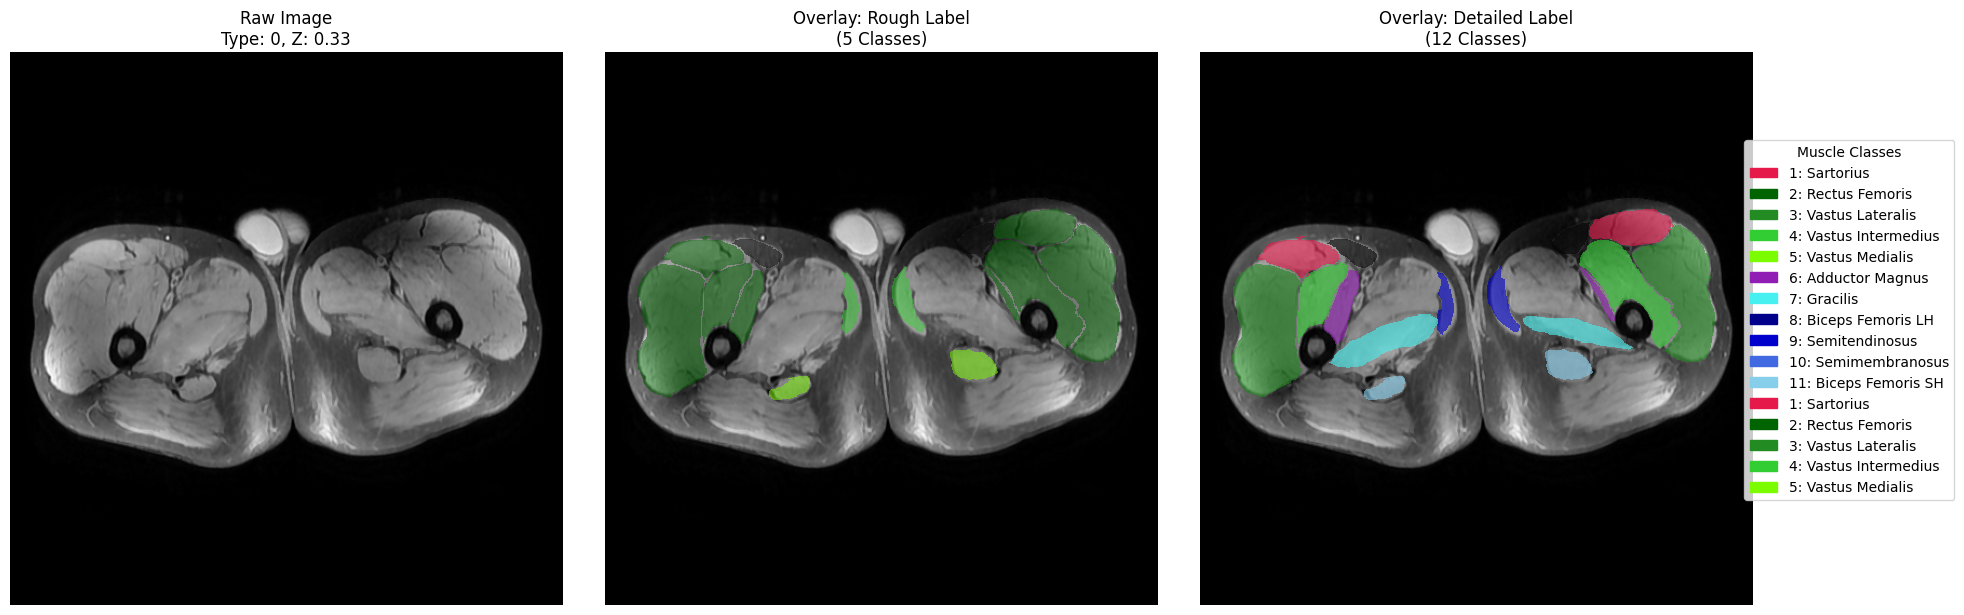


Checking Sample 2: 256_2_THIGH_050_T1_slice010.npy
- z_pos: 0.2308, type_idx: 2, has_detail: True, MRI sample: THIGH_050, Slice: 11/14


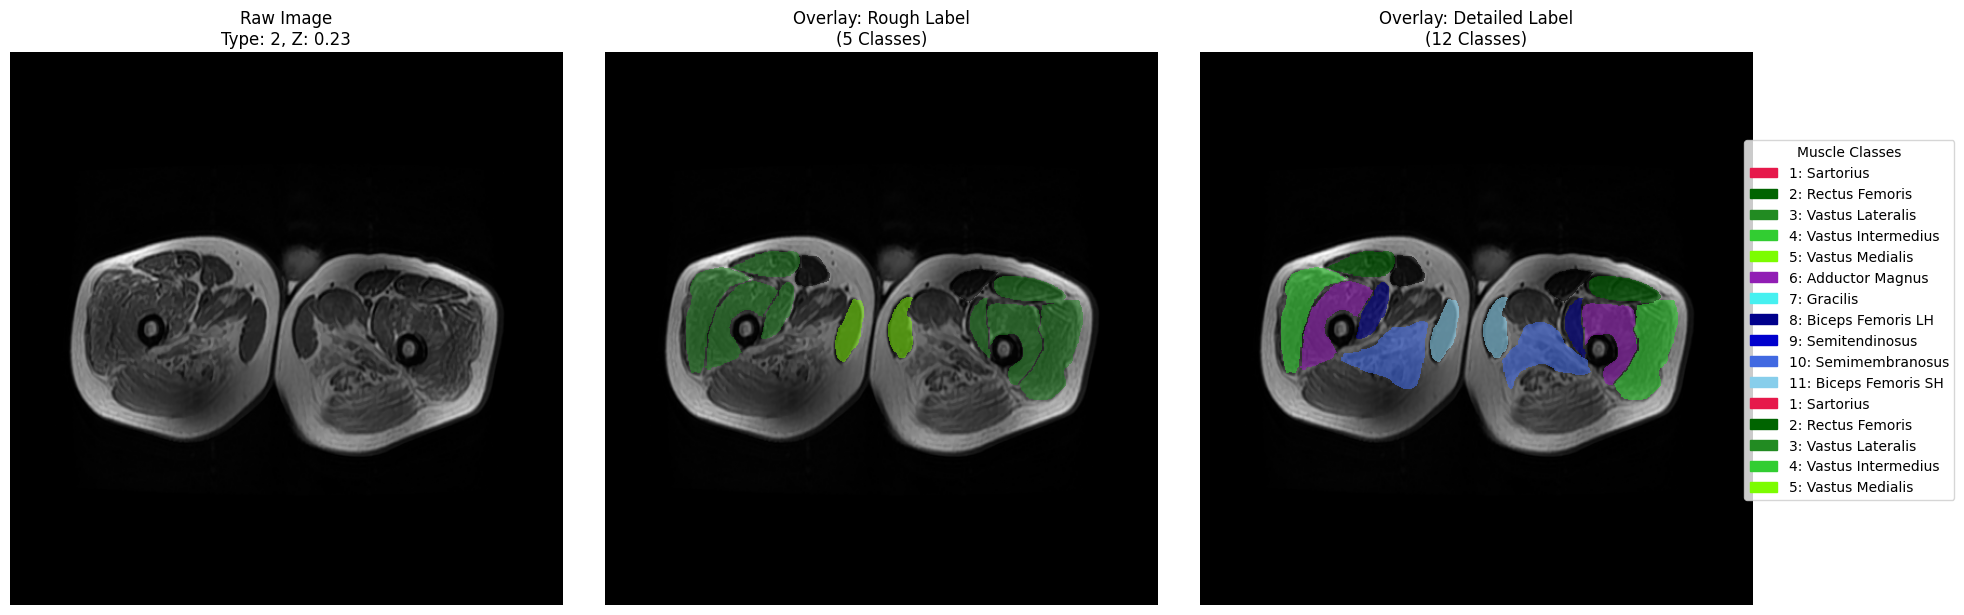


Checking Sample 3: 508_1_HV009_1_FATFRACTION_slice052.npy
- z_pos: 0.5906, type_idx: 1, has_detail: False, MRI sample: HV009_1, Slice: 53/128


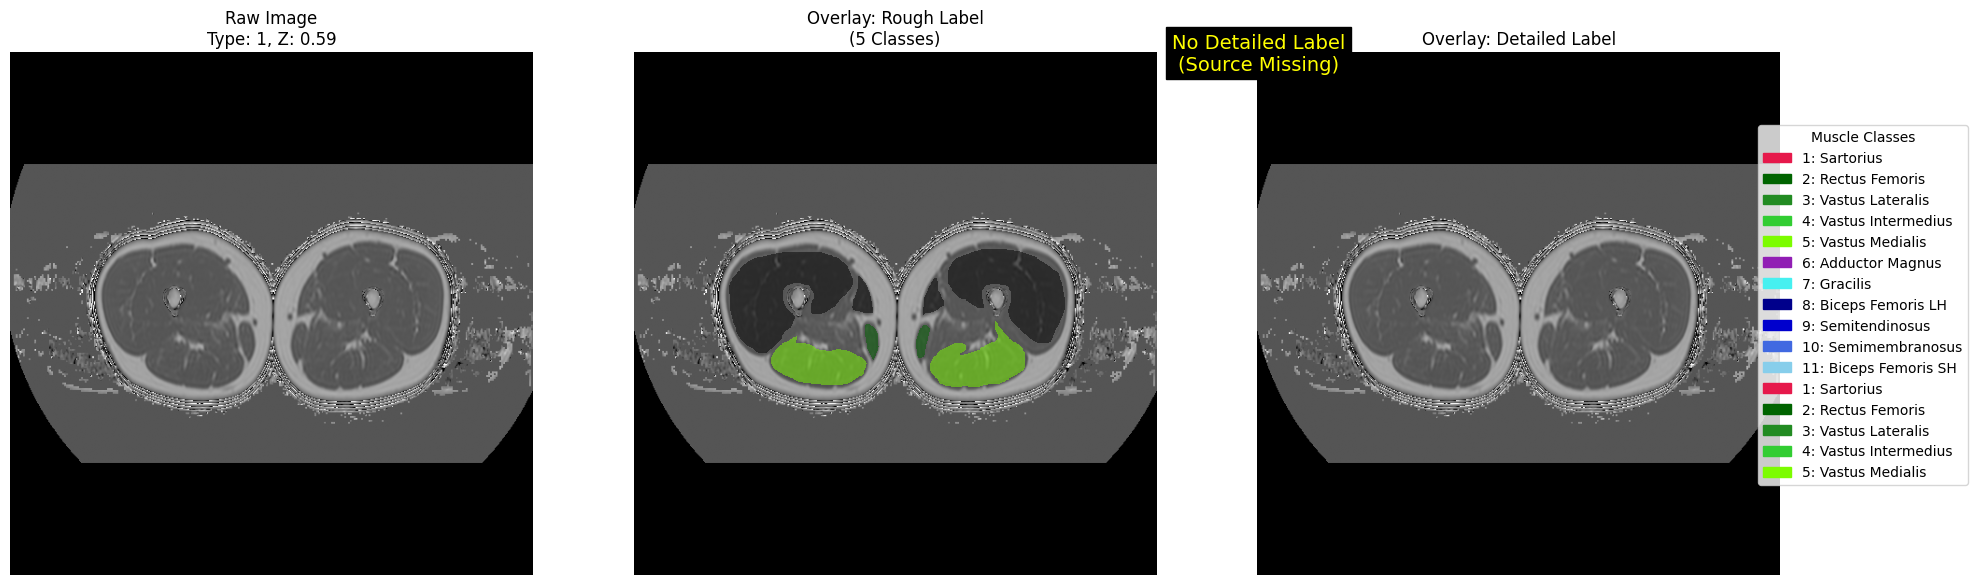


Checking Sample 4: 438_0_HV001_3_WATER_slice021.npy
- z_pos: 0.8346, type_idx: 0, has_detail: False, MRI sample: HV001_3, Slice: 22/128


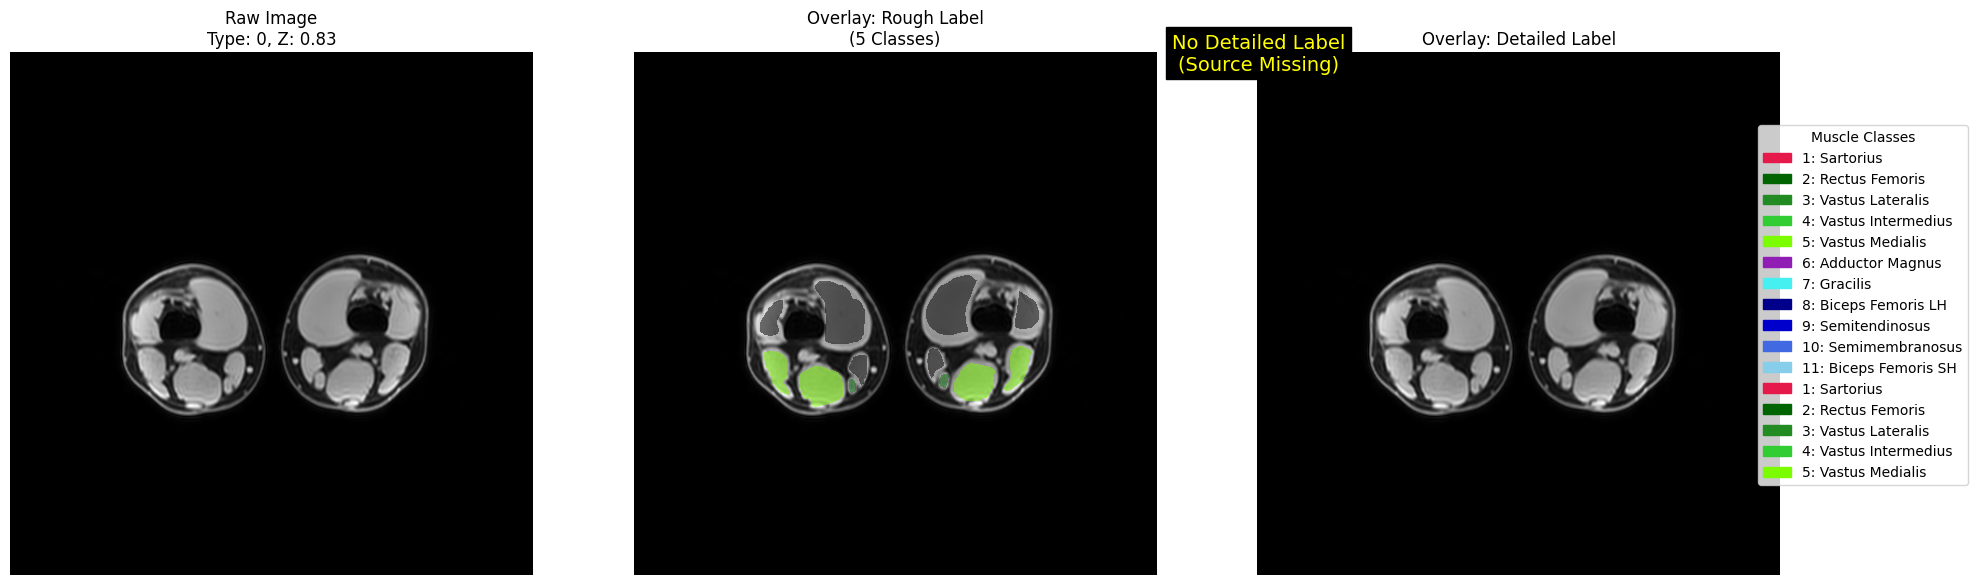


Checking Sample 5: 378_4_THIGH_113_STIR_slice003.npy
- z_pos: 0.7500, type_idx: 4, has_detail: True, MRI sample: THIGH_113, Slice: 4/13


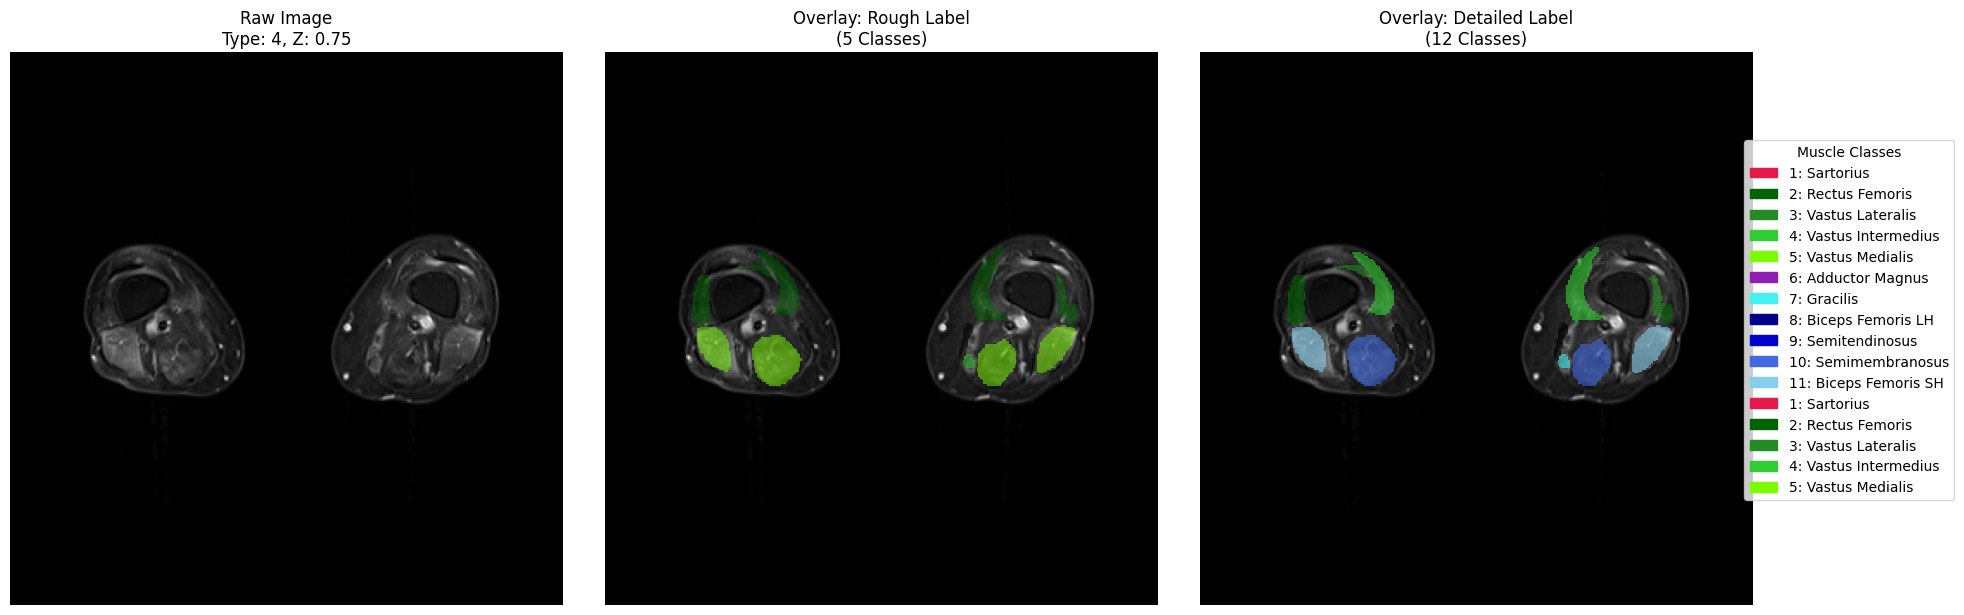


Checking Sample 6: 468_0_HV003_2_WATER_slice073.npy
- z_pos: 0.4252, type_idx: 0, has_detail: False, MRI sample: HV003_2, Slice: 74/128


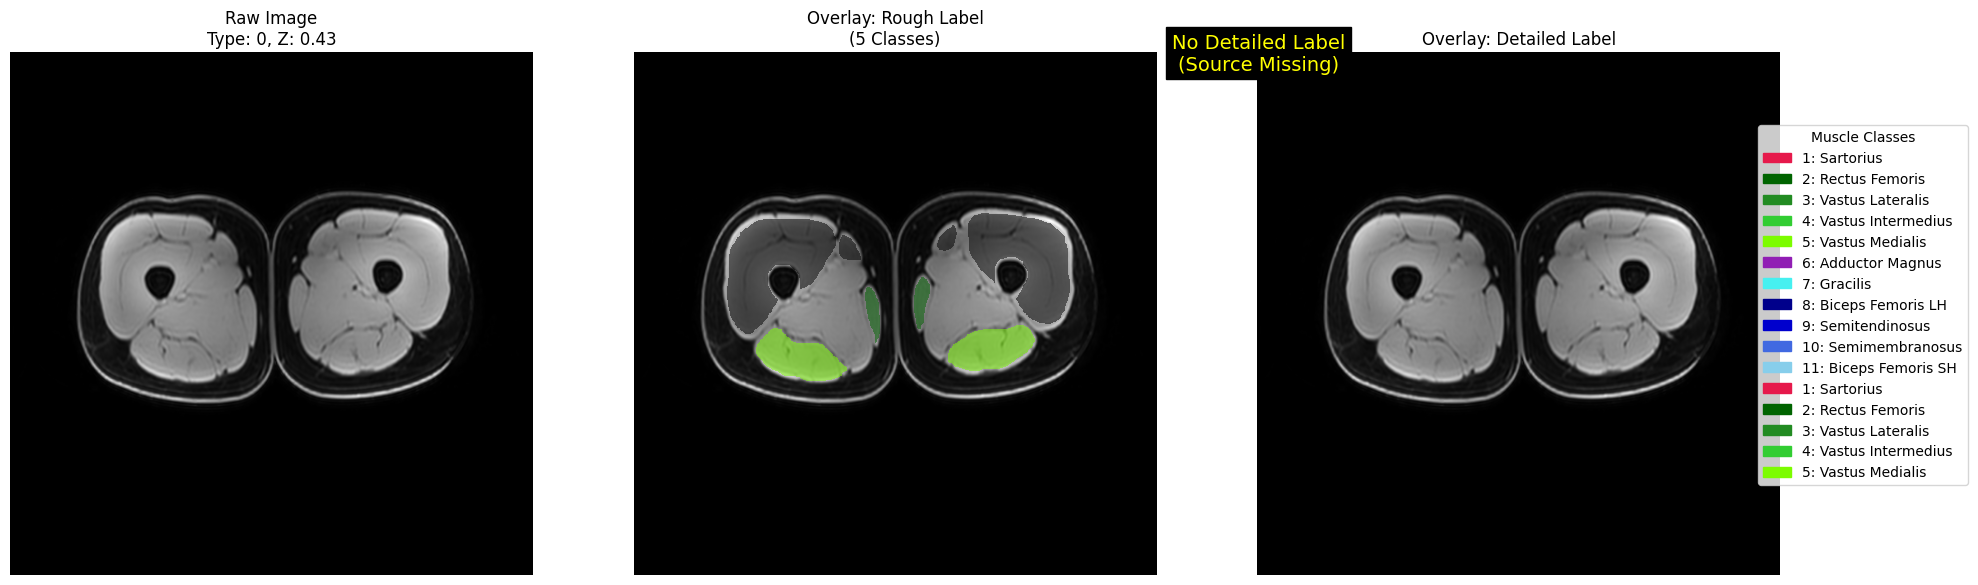


Checking Sample 7: 486_0_HV005_1_WATER_slice050.npy
- z_pos: 0.6063, type_idx: 0, has_detail: False, MRI sample: HV005_1, Slice: 51/128


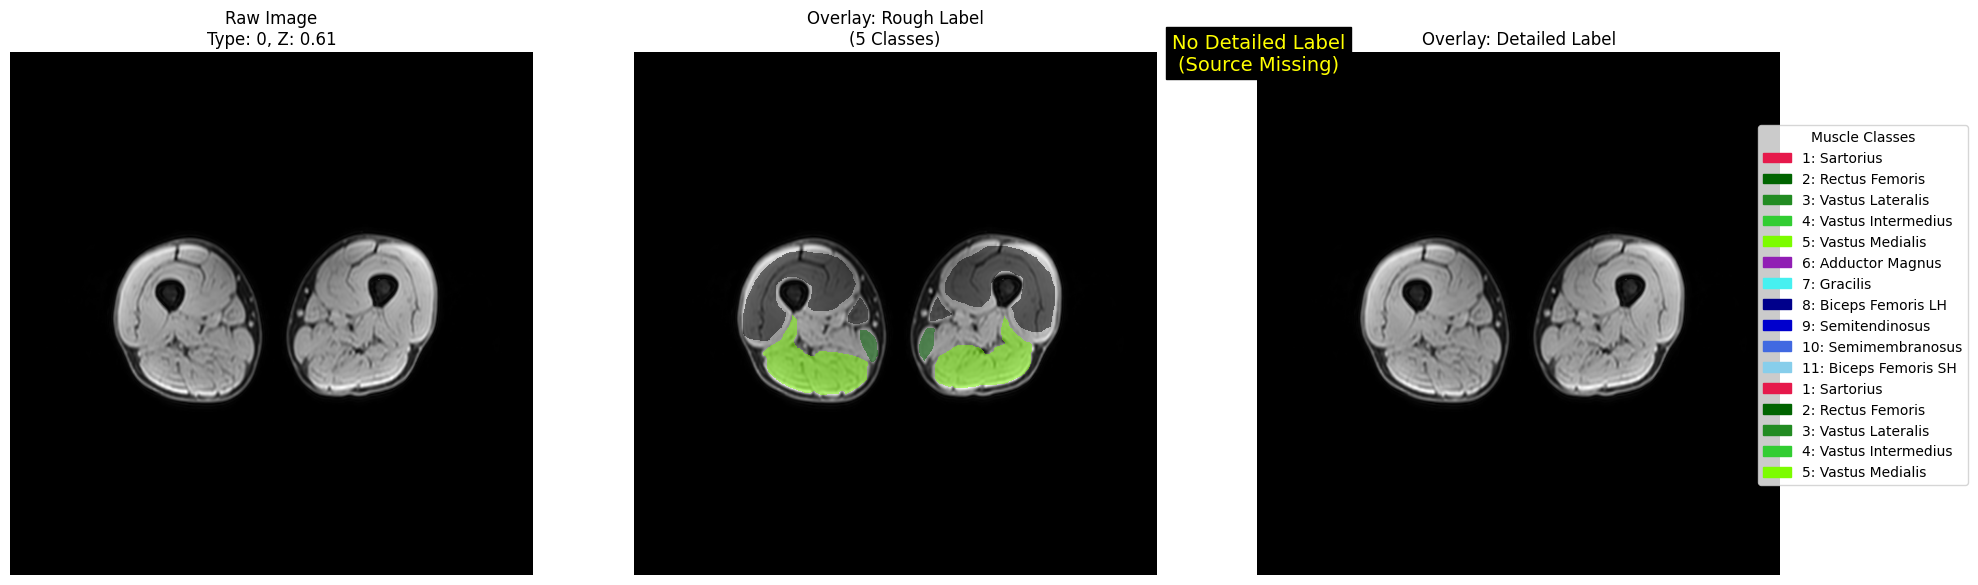


Checking Sample 8: 518_1_HV011_1_FAT_slice028.npy
- z_pos: 0.7795, type_idx: 1, has_detail: False, MRI sample: HV011_1, Slice: 29/128


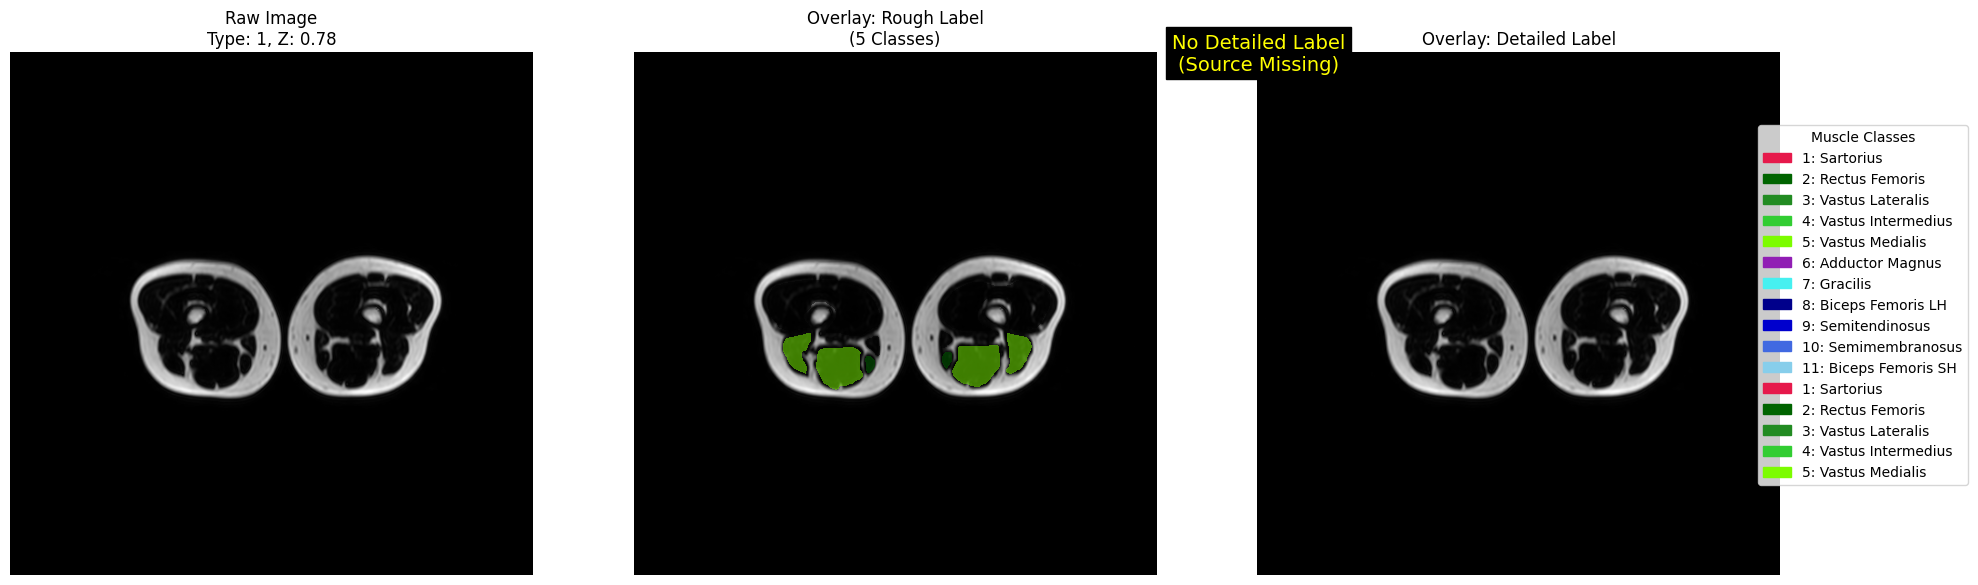


Checking Sample 9: 159_1_THIGH_031_Fat_slice000.npy
- z_pos: 1.0000, type_idx: 1, has_detail: True, MRI sample: THIGH_031, Slice: 1/14


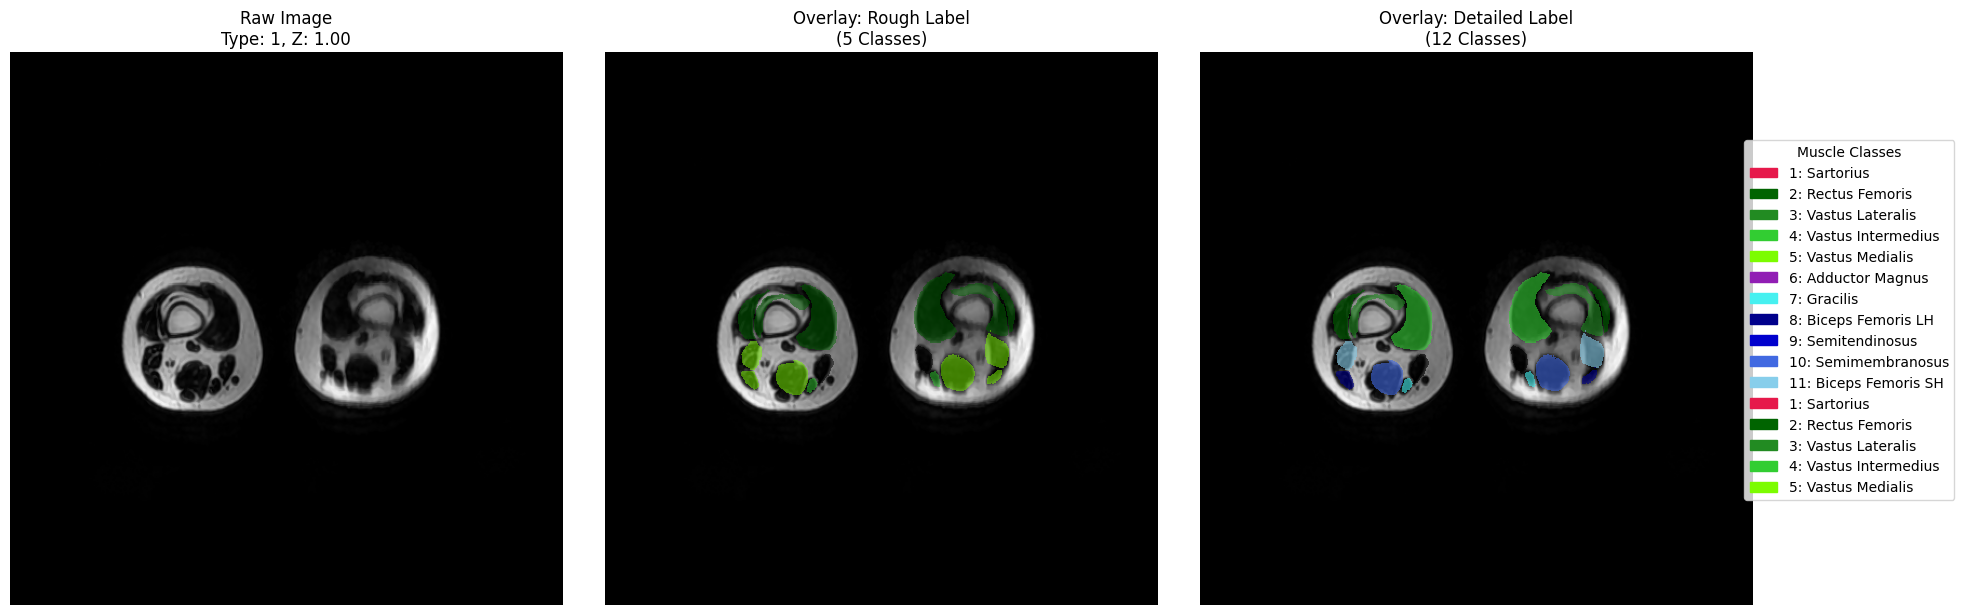


Checking Sample 10: 472_1_HV003_3_FATFRACTION_slice029.npy
- z_pos: 0.7717, type_idx: 1, has_detail: False, MRI sample: HV003_3, Slice: 30/128


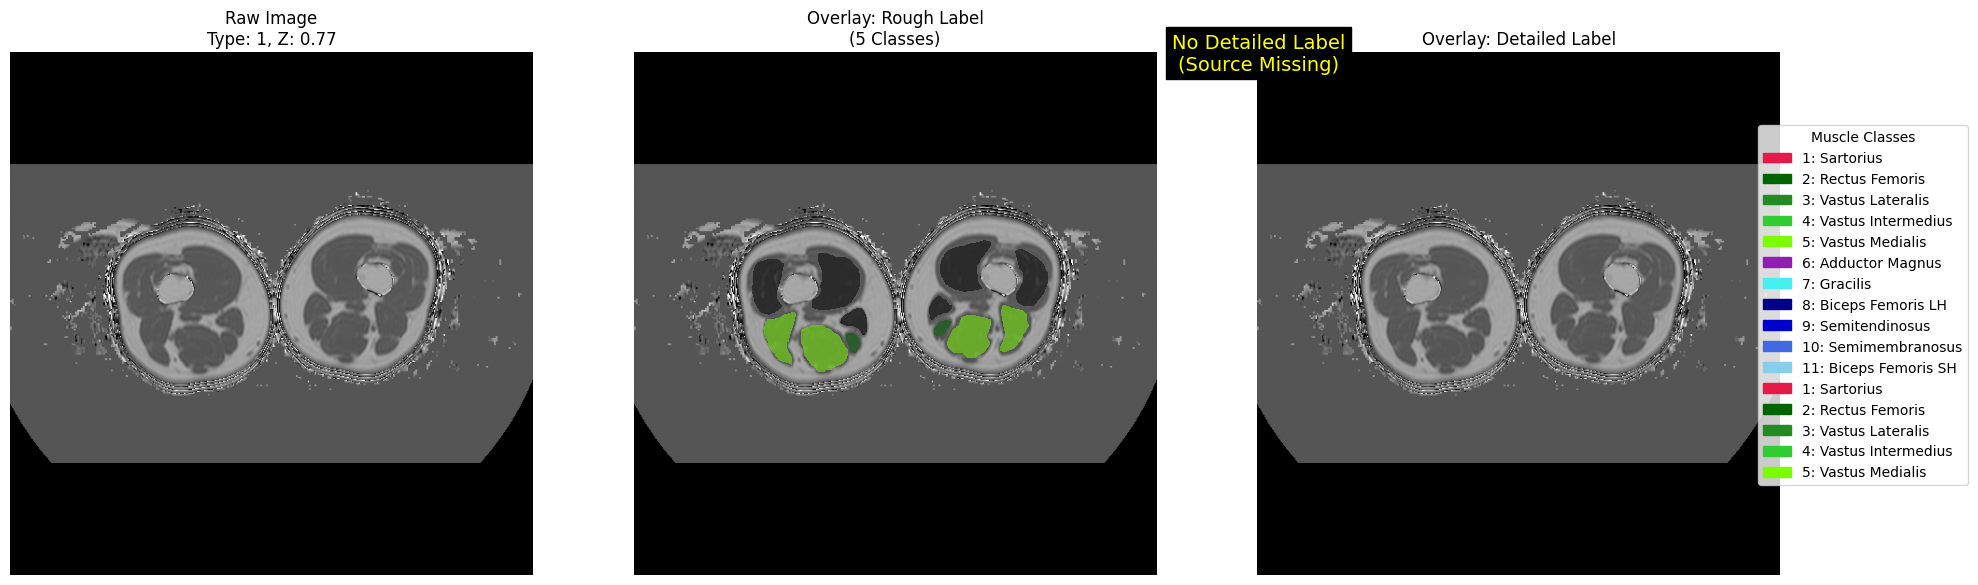

In [9]:
# 設定你的 .npy 資料夾 (請確認路徑是否正確，例如是否在 train/image 底下)
npy_dir = os.path.join(OUTPUT_SLICE_DIR,'train')

cmap_rough = mcolors.ListedColormap(POSITION_ROUGH_EMBEDDING_COLORS)
cmap_detailed = mcolors.ListedColormap(POSITION_DETAILED_EMBEDDING_COLORS)


# 1. 搜尋檔案
files = glob.glob(os.path.join(npy_dir, "*.npy"))
print(f"Found {len(files)} .npy slices.")

if len(files) == 0:
    print("Error: No files found. Check your directory path.")
else:
    # 2. 隨機抽樣 3 張來檢查
    samples = random.sample(files, 10)

    for i, fpath in enumerate(samples):
        print(f"\n" + "="*50)
        print(f"Checking Sample {i+1}: {os.path.basename(fpath)}")
        
        # 讀取
        data = np.load(fpath, allow_pickle=True).item()
        
        # 提取資料 (注意 Key 名稱需對應存檔時的設定)
        img = data['image']
        lbl_rough = data.get('rough_label')   # 粗標註
        lbl_detail = data.get('detail_label') # 細標註
        has_detail = data.get('has_detail', False)
        z_pos = data.get('z_pos', -1)
        type_idx = data.get('type_idx', -1)
        MRI_sample = data.get('MRI_sample', 'Unknown')
        this_slice = data.get('this_slice', -1)
        total_slices = data.get('total_slices', -1)
        print(f"- z_pos: {z_pos:.4f}, type_idx: {type_idx}, has_detail: {has_detail}, MRI sample: {MRI_sample}, Slice: {this_slice}/{total_slices}")
        
        # --- 建立畫布 (1列 3行) ---
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # 共用的顯示設定
        title_fontsize = 12
        
        # === Plot 1: 原圖 (Raw Image) ===
        axes[0].imshow(img, cmap='gray')
        axes[0].set_title(f"Raw Image\nType: {type_idx}, Z: {z_pos:.2f}", fontsize=title_fontsize)
        axes[0].axis('off')
        
        # === Plot 2: 原圖 + Rough Label (Overlay) ===
        axes[1].imshow(img, cmap='gray') # 先畫底圖
        if lbl_rough is not None:
            # 將背景 (0) 遮罩起來，使其完全透明
            masked_rough = ma.masked_where(lbl_rough == 0, lbl_rough)
            # 疊加 Label (alpha=0.5 半透明, cmap='tab10' 顏色對比高)
            axes[1].imshow(masked_rough, cmap=cmap_rough, alpha=0.5, interpolation='nearest')
            axes[1].set_title(f"Overlay: Rough Label\n(5 Classes)", fontsize=title_fontsize)
        else:
            axes[1].text(0.5, 0.5, "No Rough Label", ha='center', color='red')
        axes[1].axis('off')
        
        # === Plot 3: 原圖 + Detailed Label (Overlay) ===
        axes[2].imshow(img, cmap='gray') # 先畫底圖
        if has_detail and lbl_detail is not None:
            # 將背景 (0) 遮罩起來
            masked_detail = ma.masked_where(lbl_detail == 0, lbl_detail)
            # 疊加 Label (使用 tab20 以區分更多類別)
            axes[2].imshow(masked_detail, cmap=cmap_detailed, alpha=0.6, interpolation='nearest')
            axes[2].set_title(f"Overlay: Detailed Label\n(12 Classes)", fontsize=title_fontsize)
        else:
            # 如果這張圖本身就沒有 Detail Label (例如只有 Rough 的資料)
            axes[2].text(0.5, 0.5, "No Detailed Label\n(Source Missing)", ha='center', va='center', color='yellow', fontsize=14, backgroundcolor='black')
            axes[2].set_title("Overlay: Detailed Label", fontsize=title_fontsize)
        axes[2].axis('off')
        
        detailed_patches = [mpatches.Patch(color=POSITION_DETAILED_EMBEDDING_COLORS[i], label=f"{i}: {DETAIL_MUSCLE_NAMES[i]}") 
                   for i in DETAIL_MUSCLE_NAMES.keys() if i > 0] # 不顯示背景
        rough_patches = [mpatches.Patch(color=POSITION_ROUGH_EMBEDDING_COLORS[i], label=f"{i}: {ROUGH_MUSCLE_NAMES[i]}") 
                   for i in ROUGH_MUSCLE_NAMES.keys() if i > 0] #
        
        # 將圖例放在最右邊
        fig.legend(handles=detailed_patches + rough_patches, loc='center right', bbox_to_anchor=(1.1, 0.5), title="Muscle Classes")
    
        
        plt.tight_layout()
        plt.show()